In [2]:
# Masters Thesis willem

import pypsa
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import numpy as np
import pickle as pkl
from sklearn.preprocessing import MinMaxScaler
import glob
from dtw import *
import itertools

plt.style.use ("bmh")
from pprint import *
import warnings
warnings.filterwarnings('ignore')

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)


    
#from sklearn_extra.cluster import KMedoids

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 40)

In [2]:
def set_parameters_from_optimized(n, n_optim):
    '''
    Function to set optimized parameters from optimized network as nominal parameters 
    of the operative network.
    -----
    Param:
    n: Optimized investment network.
    n_optim: Operative network for redispatch simulation.
    '''
    # set line capacities to optimized
    lines_typed_i = n.lines.index[n.lines.type != '']
    n.lines.loc[lines_typed_i, 'num_parallel'] = \
        n_optim.lines['num_parallel'].reindex(lines_typed_i, fill_value=0.)
    n.lines.loc[lines_typed_i, 's_nom'] = (
        np.sqrt(3) * n.lines['type'].map(n.line_types.i_nom) *
        n.lines.bus0.map(n.buses.v_nom) * n.lines.num_parallel)
    
    lines_untyped_i = n.lines.index[n.lines.type == '']
    for attr in ('s_nom', 'r', 'x'):
        n.lines.loc[lines_untyped_i, attr] = \
            n_optim.lines[attr].reindex(lines_untyped_i, fill_value=0.)
    n.lines['s_nom_extendable'] = False
    
    # set link capacities to optimized (HVDC links as well as store out/inflow links)
    links_dc_i = n.links.index[n.links.carrier == 'DC']
    n.links.loc[links_dc_i, 'p_nom'] = \
        n_optim.links['p_nom_opt'].reindex(links_dc_i, fill_value=0.)
    n.links.loc[links_dc_i, 'p_nom_extendable'] = False
    
    # set extendable generators to optimized and p_nom_extendable to False
    gen_extend_i = n.generators.index[n.generators.p_nom_extendable]
    n.generators.loc[gen_extend_i, 'p_nom'] = \
        n_optim.generators['p_nom_opt'].reindex(gen_extend_i, fill_value=0.)
    n.generators.loc[gen_extend_i, 'p_nom_extendable'] = False
    
    # set extendable storage unit power to ooptimized
    stor_extend_i = n.storage_units.index[n.storage_units.p_nom_extendable]
    n.storage_units.loc[stor_extend_i, 'p_nom'] = \
        n_optim.storage_units['p_nom_opt'].reindex(stor_extend_i, fill_value=0.)
    n.storage_units.loc[stor_extend_i, 'p_nom_extendable'] = False
    return n

def print_lopf_insights(network):
    # generator power
    print(" \nGenerator active power per snapshot:")
    print(network.generators_t.p)

    # network line flows
    print(" \nLine active power per snapshot:")
    print(network.lines_t.p0)
    
    # relative line loading
    print(" \nRelative line loading per snapshot:")
    print(abs(network.lines_t.p0)/network.lines.s_nom)
    max_loading = (network.lines_t.p0/network.lines.s_nom).max(axis = 0)
    print(max_loading)

    #In linear approximation, all voltage magnitudes are nominal, i.e. 1 per unit
    print(" \nVoltage magnitude at nodes:")
    print(network.buses_t.v_mag_pu)

    #At bus 2 the price is set above any marginal generation costs in the model, because to dispatch to
    #it from expensive generator 0, also some dispatch from cheap generator 1 has to be substituted from generator0
    #to avoid overloading line 1.
    print(" \nMarginal prices at nodes:")
    print(network.buses_t.marginal_price)

def clean_batteries(network):
    """
    Clean up all previously saved battery components (FROM PYPSA-EUR) related to redispatch (does NOT delete the inital batteries)
    """
    network.mremove("StorageUnit", [name for name in network.storage_units.index.tolist() 
                                    if network.storage_units.loc[name]["carrier"] == "battery"])
    network.mremove("Link", [name for name in network.links.index.tolist()
                             if "BESS" in name])
    network.mremove("Store", [name for name in network.stores.index.tolist()
                             if "BESS" in name])
    network.mremove("Bus", [name for name in network.buses.index.tolist()
                           if "BESS" in name])
    
def add_BESS_loadflexibility(network, network_year, flex_potential = 10000, c_rate = 0.25, flex_share = 0.1):
    '''
    Adds battery storages at every node, depending on the flexibility potential of the loads allocated to this node. 
    Methodology according to Network development plan and Frontier study:
        - Flexibility potential at load-nodes: Flexibility Potential through stationary battery storage in distribution grids
        - Flexibility potential at power plants: Flexibility through battery installations at powerplants (by operators)
    
    Following the assumption of x percentage of frontier flexibility potential being installed at node according to loads. 
    Flexibility potential can e.g. be aggregated powerwall capacity at the node.
    -----
    Param:
    network: network from dispatch optimization 
    network_year: full time resolution network (typically 1 year)
    flex_potential: Total flexibility potential from distribution grid (default: frontier-study potential)
    '''
    # Clean up all previously saved battery components
    clean_batteries(network)
    # get bus names
    bus_names = network.buses.index.tolist()
    # get mean load at every bus
    df_loads = network_year.loads
    df_loads["p_mean"] = network_year.loads_t.p_set.mean(axis = 0)
    
    # According to x% rule, add energy stores with energy = x% of average load at bus
    for i in range(len(bus_names)):
        bus_name = network.buses.index.tolist()[i]
        battery_bus = "{}_{}".format(bus_name,"BESS")
        # determin flexibility at bus
        df_loads_bus = df_loads[df_loads["bus"] == bus_name]
        
        ################
        
        
        # TODO: ÄNDERN DER maximalen energie: Die speicherbare energie soll abhängig vom mittelwert der last 
        # über den GESAMTEN zeitraum sein, nicht nur vom mittelwert des aktuellen (1 day) networks!
        
        
        ################
        
        if not df_loads_bus.empty:
            p_flex = df_loads_bus.p_mean * flex_share
        else:
            p_flex = 0
            
        print("p_flex = " + str(p_flex))

        # add additional bus solely for representation of battery at location of previous bus
        network.add("Bus",
                    name = battery_bus,
                    x = network.buses.loc[bus_name,"x"],
                    y = network.buses.loc[bus_name,"y"],
                    carrier = "battery")
        # add store
        network.add("Store", name = "BESS_{}".format(i),
                    bus = battery_bus,
                    e_nom = p_flex / c_rate,
                    e_nom_extendable = False,
                    e_min_pu = 0,
                    e_max_pu = 1,
                    e_initial = 0.5,
                    e_cyclic = False,
                    p_set = p_flex,
                    q_set = 0.05,
                    marginal_cost = 0,
                    capital_cost = 0,
                    standing_loss = 0)
        # discharge link
        network.add("Link",
                    name = "BESS_{}_discharger".format(i+1),
                    bus0 = battery_bus,
                    bus1 = bus_name,
                    capital_cost = 0,
                    p_nom = p_flex,
                    p_nom_extendable = False,
                    p_max_pu = 1,
                    p_min_pu = 0,
                    marginal_cost = 0,
                    efficiency = 0.96)
        # charge link
        network.add("Link",
                    name = "BESS_{}_charger".format(i+1),
                    bus0 = bus_name,
                    bus1 = battery_bus,
                    capital_cost = 0,
                    p_nom = p_flex,
                    p_nom_extendable = False,
                    p_max_pu = 1,
                    p_min_pu = 0,
                    marginal_cost = 0,
                    efficiency = 0.96)
    network.name = str(network.name) + " BESS loadflexibility"
        
def add_BESS(network):
    '''
    Adds static battery storages (fixed capacity) to the base network
    Removes previously added batteries (links and stores) from the network
    
    A battery is added to the network by combining a link for discharge, and one for charge (representing inverter operations)
    and a store unit representing the battery capacity
    '''
    # Clean up all previously saved battery components
    clean_batteries(network)
    
    bus_names = network.buses.index.tolist()
    for i in range(len(bus_names)):
        bus_name = bus_names[i]
        battery_bus = "{}_{}".format(bus_name,"BESS")
        # add additional bus solely for representation of battery at location of previous bus
        network.add("Bus",
                    name = battery_bus,
                    x = network.buses.loc[bus_name,"x"],
                    y = network.buses.loc[bus_name,"y"],
                    carrier = "battery")
        # discharge link
        network.add("Link",
                    name = "Battery_{}_dCH".format(i+1),
                    bus0 = battery_bus,
                    bus1 = bus_name,
                    capital_cost = 0,
                    p_nom = 150,
                    p_nom_extendable = False,
                    p_max_pu = 1,
                    p_min_pu = 0,
                    marginal_cost = 0,
                    efficiency = 0.96)
        # charge link
        network.add("Link",
                    name = "Battery_{}_CH".format(i+1),
                    bus0 = bus_name,
                    bus1 = battery_bus,
                    capital_cost = 0,
                    p_nom = 150,
                    p_nom_extendable = False,
                    p_max_pu = 1,
                    p_min_pu = 0,
                    marginal_cost = 0,
                    efficiency = 0.96)
        # add store
        network.add("Store", name = "BESS_{}".format(i),    
                    bus = battery_bus,
                    e_nom = 200,
                    e_nom_extendable = False,
                    e_min_pu = 0,
                    e_max_pu = 1,
                    e_initial = 0.5,
                    e_cyclic = True,
                    p_set = 100,
                    q_set = 0.05,
                    marginal_cost = 0,
                    capital_cost = 0,
                    standing_loss = 0)
    network.name = str(network.name) + " BESS"
    
        
def clean_generators(network):
    """
    Remove all generators from network
    """
    network.mremove("Generator", [name for name in network.generators.index.tolist()])


def build_redispatch_network(network, network_dispatch):
    '''
    Uses predefined component building functions for building the redispatch network.
    Passes the dispatch per generator as fixed generation for each generator.
    Adds a ramp down generator (neg. redispatch) and ramp up generator (pos. redispatch) for each conventional generator.
    Adds a ramp down generator (curtailment) for each EE generator.
    -----
    Parameters:
    network: network representing one day of snapshots (not optimized)
    network_dispatch: network from dispatch optimization (one node market model)
    '''
    # Copy initial network and remove generators for redispatch step
    network_redispatch = network.copy()
    clean_generators(network_redispatch)
    
    # Add new generators for redispatch calculation
    l_generators = network.generators.index.tolist()
    l_conv_carriers = ["hard coal","lignite","gas","oil","nuclear","OCGT","CCGT"]
    
    for generator in l_generators:
        
        # For each conventional generator in network: Add 3 generators in network_redispatch
        if network.generators.loc[generator]["carrier"] in l_conv_carriers:
            # Base generator from network, power range is fixed by dispatch simulation results (therefore runs at 0 cost)
            network_redispatch.add("Generator",
                                   name = "{}".format(generator), 
                                   bus = network.generators.loc[generator]["bus"],
                                   p_nom = network.generators.loc[generator]["p_nom"],
                                   efficiency = network.generators.loc[generator]["efficiency"],
                                   marginal_cost = 0,
                                   capital_cost = 0,
                                   carrier = network.generators.loc[generator]["carrier"],
                                   p_max_pu = (network_dispatch.generators_t.p[generator] / network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
                                   p_min_pu = (network_dispatch.generators_t.p[generator] / network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
                                  )
            # Upwards generator (positive redispatch) ranges within the difference of the base power p_max_pu (e.g. 0.92) and p_max_pu = 1
            network_redispatch.add("Generator",
                                   name = "{}_pos".format(generator), 
                                   bus = network.generators.loc[generator]["bus"],
                                   p_nom = network.generators.loc[generator]["p_nom"],
                                   efficiency = network.generators.loc[generator]["efficiency"],
                                   marginal_cost = network.generators.loc[generator]["marginal_cost"],
                                   capital_cost = 0,
                                   carrier = network.generators.loc[generator]["carrier"],
                                   p_max_pu = (1 - network_dispatch.generators_t.p[generator] / network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
                                   p_min_pu = 0,
                                  )
            # Downwards generator (negative redispatch): Using this generator reduces the energy feed in at specific bus, 
            # but increases costs for curtialment. Cost for curtailment = lost profit for not feeding in - savings through ramp down 
            network_redispatch.add("Generator",
                                   name = "{}_neg".format(generator), 
                                   bus = network.generators.loc[generator]["bus"],
                                   p_nom = network.generators.loc[generator]["p_nom"],
                                   efficiency = network.generators.loc[generator]["efficiency"],
                                   marginal_cost = (network.generators.loc[generator]["marginal_cost"] - network_dispatch.buses_t.marginal_price[network_dispatch.generators.loc[generator]["bus"]]).tolist(),
                                   capital_cost = 0,
                                   p_max_pu = 0,
                                   carrier = network.generators.loc[generator]["carrier"],
                                   p_min_pu = (- network_dispatch.generators_t.p[generator] / network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
                                  )
            
        else:
            # For renewable sources: Only add base and negative generator, representing the curtailment of EE 
            network_redispatch.add("Generator",
                                   name = "{}".format(generator), 
                                   bus = network.generators.loc[generator]["bus"],
                                   p_nom = network.generators.loc[generator]["p_nom"],
                                   efficiency = network.generators.loc[generator]["efficiency"],
                                   marginal_cost = 0,
                                   capital_cost = 0,
                                   carrier = network.generators.loc[generator]["carrier"],
                                   p_max_pu = (network_dispatch.generators_t.p[generator] / network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
                                   p_min_pu = (network_dispatch.generators_t.p[generator] / network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
                                  )
            # Downwards generator (negative redispatch): Using this generator reduces the energy feed in at specific bus, 
            # but increases costs for curtialment. Cost for curtailment = lost profit for not feeding in - savings through ramp down 
            network_redispatch.add("Generator",
                                   name = "{}_neg".format(generator), 
                                   bus = network.generators.loc[generator]["bus"],
                                   p_nom = network.generators.loc[generator]["p_nom"],
                                   efficiency = network.generators.loc[generator]["efficiency"],
                                   marginal_cost = (network.generators.loc[generator]["marginal_cost"] - network_dispatch.buses_t.marginal_price[network_dispatch.generators.loc[generator]["bus"]]).tolist(),
                                   capital_cost = 0,
                                   p_max_pu = 0,
                                   carrier = network.generators.loc[generator]["carrier"],
                                   p_min_pu = (- network_dispatch.generators_t.p[generator] / network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
                                  )
    network_redispatch.name = str(network_redispatch.name) + " redispatch"
    return network_redispatch


def build_market_model(network):
    '''
    Clusters all generators, loads, stores and storage units to a single (medoid) bus to emulate market simulation.
    For faster computation: Assign to first bus of dataset
    TODO: For multiple countries, the dataset to be clusterd first needs to be separated by country (groupby("country")) and then clustered.
    '''  
    mode = "default"
    network_dispatch = network.copy()
    
    # cluster all buses to the center one and assign all grid elements to that bus
    df_busmap = network_dispatch.buses
    
    if mode == "cluster":
        # Cluster buses to 1 cluster & compute center
        np_busmap = df_busmap[["x","y"]].to_numpy()
        k_medoids = KMedoids(n_clusters=1, metric='euclidean', init='k-medoids++', max_iter=300, random_state=None)
        score = k_medoids.fit(np_busmap)
        x_medoid = k_medoids.cluster_centers_[0][0]
        y_medoid = k_medoids.cluster_centers_[0][1]
        # find single medoid bus in dataframe
        market_bus = df_busmap[(df_busmap["x"] == x_medoid) & (df_busmap["y"] == y_medoid)].squeeze()
        bus_name = str(market_bus.name) # save bus name, remove brackets & quotemarks
    else:
        #bus_name = str(df_busmap[0].index.values)[2:-2]
        bus_name = df_busmap.iloc[0].name

    # assign all generators, loads, storage_units, stores to the medoid bus (market_bus)
    network_dispatch.loads["bus"] = bus_name
    network_dispatch.generators["bus"] = bus_name
    network_dispatch.stores["bus"] = bus_name
    network_dispatch.storage_units["bus"] = bus_name
    return network_dispatch

def solve_redispatch_network(network, network_dispatch):
    '''
    Calls the building function and solves the network under redispatch constraints.
    -----
    Parameters:
    network: network from dispatch optimization
    '''
    #### TODO: add extra functionality that only pos OR negative can be =! 0 during 1 snapshot    

    network_redispatch = build_redispatch_network(network, network_dispatch)
    # Solve new network
    network_redispatch.lopf(solver_name="gurobi", pyomo = False, 
                 formulation ="kirchhoff")
    return network_redispatch 
    
# Redispatch workflow with batteries
def build_redispatch_network_with_bat(network, network_dispatch, network_year, c_rate, flex_share, flex_store = True):
    '''
    Uses predefined component building functions for building the redispatch network and adds batteries.
    -----
    Parameters:
    network: network from dispatch optimization 
    '''
    network_redispatch_bat = build_redispatch_network(network, network_dispatch)
    # Adding a battery at every node
    if flex_store == True:
        add_BESS_loadflexibility(network_redispatch_bat, network_year, c_rate, flex_share)
    else:
        add_BESS(network_redispatch_bat)
        
    return network_redispatch_bat
    
def solve_redispatch_network_with_bat(network, network_dispatch, network_year, c_rate, flex_share,flex_store = True):
    '''
    Calls redispatch building function and solves the network.
    -----
    Parameters:
    network: network from dispatch optimization 
    '''
    
    #### TODO: add extra functionality that only pos OR negative can be =! 0 during 1 snapshot    

    network_redispatch_bat = build_redispatch_network_with_bat(network, network_dispatch, network_year, c_rate, flex_share,flex_store = True,)
    # Solve new network
    network_redispatch_bat.lopf(solver_name="gurobi", pyomo = False, formulation ="kirchhoff")
    
    return network_redispatch_bat



def concat_network(list_networks, ignore_standard_types = False):
    '''
    Function that merges technically identical, but temporally decoupled networks by concatenating 
    their time-dependent components (input & output)
    -----
    Param:
    l_networks: list of daily solved networks (can be either l_networks_dispatch or l_networks_redispatch)
    scenario: Determines whether input networks will have stores or not
    '''
    from pypsa.io import (import_components_from_dataframe, import_series_from_dataframe)
    from six import iterkeys

    #create new network out of first network of the list of identical networks 
    n_input = list_networks[0].copy()

    # Copy time indipendent components
    # -------------------
    override_components, override_component_attrs = n_input._retrieve_overridden_components()
    nw = n_input.__class__(ignore_standard_types=ignore_standard_types,
                                     override_components=override_components,
                                     override_component_attrs=override_component_attrs)

    for component in n_input.iterate_components(["Bus", "Carrier"] + sorted(n_input.all_components - {"Bus","Carrier"})):
        df = component.df
        #drop the standard types to avoid them being read in twice
        if not ignore_standard_types and component.name in n_input.standard_type_components:
            df = component.df.drop(nw.components[component.name]["standard_types"].index)
        import_components_from_dataframe(nw, df, component.name)
    
    # Time dependent components
    # --------------------
    # set snapshots
    snapshots = n_input.snapshots
    for network in list_networks[1:]:
        snapshots = snapshots.union(network.snapshots)
    nw.set_snapshots(snapshots)   

    # concat time dependent components from all networks in input list
    for component in nw.iterate_components(["Bus", "Carrier"] + sorted(n_input.all_components - {"Bus","Carrier"})):
        component_t = component.list_name + "_t"
        
        for attr, timeseries in component.pnl.items():
            l_component = []
            for network in list_networks:
                #each time dependent dataframe
                l_component.append(getattr(getattr(network, component_t),attr))
            # concat the components list to dataframe
            df_component = pd.concat(l_component, axis = 0)
            # import time series from dataframe for output network
            import_series_from_dataframe(nw, df_component, component.name, attr)
    
    #catch all remaining attributes of network
    for attr in ["name", "srid"]:
        setattr(nw,attr,getattr(n_input,attr))  
    
    # Concat objective value for partially solved networks
    obj = 0
    for network in list_networks:
        if hasattr(network, 'objective'):
            obj = obj + network.objective
    nw.objective = obj 

    return nw

def redispatch_workflow(network, network_optim, scenario = "no bat",  
                        c_rate = 0.25, flex_share = 0.1 ,flex_store = True):
    '''
    Function for executing the whole redispatch workflow.
    
    -----
    Param:
    network: Un-optimized network from pypsa-eur.
    network_optim: Already optimized network from the strategic network optimization in pypsa-eur.
    scenario: "bat" or "no bat" decides whether the redispatch optimization is run with or without batteries.
    Return:
    l_networks_list: List of solved daily dispatch and redispatch networks.
    '''
    # create lists to save results
    network_year = network
    l_networks_24 = []
    l_networks_dispatch = []
    l_networks_redispatch = []
    dict_obj_d = {}
    dict_obj_rd = {}
    
    # Generate operative pypsa-eur network without investment problem
    network = set_parameters_from_optimized(network, network_optim)
    
    # Only operative optimization: Capital costs set to zero
    network.generators.loc[:,"capital_cost"] = 0
    
    # Run dispatch_redispatch workflow for every day (24h batch)
    for start_hour in range(0, len(network.snapshots), 24):

        #print(start_hour)
        n_24 = network.copy(snapshots = network.snapshots[start_hour:start_hour+24])
        
        # Build market model, solve dispatch network and plot network insights
        # ---------------
        n_dispatch = build_market_model(n_24)
        n_dispatch.lopf(solver_name="gurobi", pyomo = False, formulation ="kirchhoff")
        
        # Call redispatch optimization and plot network insights
        # ---------------
        if scenario == "no bat":
            n_redispatch = solve_redispatch_network(n_24, n_dispatch)
        elif scenario == "bat":
            n_redispatch = solve_redispatch_network_with_bat(n_24, n_dispatch, network_year, c_rate = 0.25, flex_share = 0.1, flex_store = True)
                
        # Append networks to corresponding yearly lists
        # ---------------
        l_networks_24.append(n_24)
        l_networks_dispatch.append(n_dispatch)
        l_networks_redispatch.append(n_redispatch)
        
        # Create output list for the daily objective values dispatch & redispatch
        # ---------------
        dict_obj_d[n_dispatch.snapshots[0].day] = n_dispatch.objective
        dict_obj_rd[n_redispatch.snapshots[0].day] = n_redispatch.objective
        
        # For each results list: Create a network out of daily networks for dispatch & redispatch
        # ---------------
        network_dispatch = concat_network(l_networks_dispatch)
        network_redispatch = concat_network(l_networks_redispatch)
           
    
    return network_dispatch, network_redispatch, dict_obj_d, dict_obj_rd
  
    
def solve_all_redispatch_workflows(c_rate = 0.25, flex_share = 0.1 ,flex_store = True):
    """
    Function to run the redispatch workflow for all networks in the networks_redispatch folder.
    """
    import pickle as pkl
    import glob
    
    folder = r'C:\Users\Willem\pypsa-eur\networks_redispatch'
    for filepath in glob.iglob(folder + '\*.nc'):
        filename = filepath.split('\\')[-1].split(".")[0]
        path_n = filepath
        path_n_optim = folder + "\solved\\" + filename +".nc"
        # Define network and network_optim
        n = pypsa.Network(path_n)
        n_optim = pypsa.Network(path_n_optim)
        
        # TEST TEST TEST
        # --------------
        nw = n.copy(snapshots = n.snapshots[0:24*7])
        nw_optim = n_optim.copy(snapshots = n_optim.snapshots[0:24*7])
        
        n_d, n_rd, dict_obj_d, dict_obj_rd = redispatch_workflow(nw, nw_optim, scenario = "no bat", 
                                         c_rate = 0.25, flex_share = 0.1 ,flex_store = True)
        n_d_bat, n_rd_bat, dict_obj_d_bat, dict_obj_rd_bat = redispatch_workflow(nw, nw_optim, scenario = "bat",
                                            c_rate = 0.25, flex_share = 0.1 ,flex_store = True)
        
        # export solved dispatch & redispatch workflow as well as objective value list
        export_path = folder + r"\results"
        n_d.export_to_netcdf(path=export_path + r"\dispatch\\" + filename + ".nc",
                             export_standard_types=False, least_significant_digit=None)
        n_rd.export_to_netcdf(path=export_path + r"\redispatch\\" + filename  + ".nc", 
                              export_standard_types=False, least_significant_digit=None)
        n_rd_bat.export_to_netcdf(path=export_path + r"\redispatch\\" + filename + "_bat.nc", 
                                  export_standard_types=False, least_significant_digit=None)
        
        # export lists with obj values
        with open(export_path + r"\dispatch\\" + filename + r".pickle","wb") as f:
            pkl.dump(dict_obj_d, f)      
        with open(export_path + r"\redispatch\\" + filename + r".pickle","wb") as f:
            pkl.dump(dict_obj_rd, f)
        with open(export_path + r"\redispatch\\" + filename + r"_bat.pickle","wb") as f:
            pkl.dump(dict_obj_rd_bat, f)
            
def redispatch_workflow(network, network_optim, scenario = "no bat",  
                        c_rate = 0.25, flex_share = 0.1 ,flex_store = True):
    '''
    Function for executing the whole redispatch workflow.
    
    -----
    Param:
    network: Un-optimized network from pypsa-eur.
    network_optim: Already optimized network from the strategic network optimization in pypsa-eur.
    scenario: "bat" or "no bat" decides whether the redispatch optimization is run with or without batteries.
    Return:
    l_networks_list: List of solved daily dispatch and redispatch networks.
    '''
    # create lists to save results
    network_year = network
    l_networks_24 = []
    l_networks_dispatch = []
    l_networks_redispatch = []
    dict_obj_d = {}
    dict_obj_rd = {}
    
    # Generate operative pypsa-eur network without investment problem
    network = set_parameters_from_optimized(network, network_optim)
    
    # Only operative optimization: Capital costs set to zero
    network.generators.loc[:,"capital_cost"] = 0
    
    # Run dispatch_redispatch workflow for every day (24h batch)
    for start_hour in range(0, len(network.snapshots), 24):

        #print(start_hour)
        n_24 = network.copy(snapshots = network.snapshots[start_hour:start_hour+24])
        
        # Build market model, solve dispatch network and plot network insights
        # ---------------
        n_dispatch = build_market_model(n_24)
        n_dispatch.lopf(solver_name="gurobi", pyomo = False, formulation ="kirchhoff")
        
        # Call redispatch optimization and plot network insights
        # ---------------
        if scenario == "no bat":
            n_redispatch = solve_redispatch_network(n_24, n_dispatch)
        elif scenario == "bat":
            n_redispatch = solve_redispatch_network_with_bat(n_24, n_dispatch, network_year, c_rate = 0.25, flex_share = 0.1, flex_store = True)
                
        # Append networks to corresponding yearly lists
        # ---------------
        l_networks_24.append(n_24)
        l_networks_dispatch.append(n_dispatch)
        l_networks_redispatch.append(n_redispatch)
        
        # Create output list for the daily objective values dispatch & redispatch
        # ---------------
        dict_obj_d[n_dispatch.snapshots[0].day] = n_dispatch.objective
        dict_obj_rd[n_redispatch.snapshots[0].day] = n_redispatch.objective
        
        # For each results list: Create a network out of daily networks for dispatch & redispatch
        # ---------------
        network_dispatch = concat_network(l_networks_dispatch)
        network_redispatch = concat_network(l_networks_redispatch)
           
    
    return network_dispatch, network_redispatch, dict_obj_d, dict_obj_rd
  
    
def solve_all_redispatch_workflows(c_rate = 0.25, flex_share = 0.1 ,flex_store = True):
    """
    Function to run the redispatch workflow for all networks in the networks_redispatch folder.
    Can also be used for a single redispatch network.
    In any case, saves analysis outputs in target directory.
    """
    single_network = True
    folder = r'C:\Users\Willem\pypsa-eur\networks_redispatch'
    # Solve a single redispatch network
    if single_network == True:
        filename = "elec_s300_50_ec_lcopt_1H"
        path_n = folder + r"\\" + filename + r".nc"
        path_n_optim = folder + r"\solved\\" + filename + r".nc"
        # Define network and network_optim
        n = pypsa.Network(path_n)
        n_optim = pypsa.Network(path_n_optim)

        # TEST TEST TEST
        # --------------
        nw = n.copy(snapshots = n.snapshots[0:24*31])
        nw_optim = n_optim.copy(snapshots = n_optim.snapshots[0:24*31])

        n_d, n_rd, dict_obj_d, dict_obj_rd = redispatch_workflow(nw, nw_optim, scenario = "no bat", 
                                         c_rate = 0.25, flex_share = 0.1 ,flex_store = True)
        n_d_bat, n_rd_bat, dict_obj_d_bat, dict_obj_rd_bat = redispatch_workflow(nw, nw_optim, scenario = "bat",
                                            c_rate = 0.25, flex_share = 0.1 ,flex_store = True)

        # export solved dispatch & redispatch workflow as well as objective value list
        export_path = folder + r"\results"
        n_d.export_to_netcdf(path=export_path + r"\dispatch\\" + filename + ".nc",
                             export_standard_types=False, least_significant_digit=None)
        n_rd.export_to_netcdf(path=export_path + r"\redispatch\\" + filename  + ".nc", 
                              export_standard_types=False, least_significant_digit=None)
        n_rd_bat.export_to_netcdf(path=export_path + r"\redispatch\\" + filename + "_bat.nc", 
                                  export_standard_types=False, least_significant_digit=None)

        # export lists with obj values
        with open(export_path + r"\dispatch\objective\\" + filename + r".pickle","wb") as f:
            pkl.dump(dict_obj_d, f)      
        with open(export_path + r"\redispatch\objective\\" + filename + r".pickle","wb") as f:
            pkl.dump(dict_obj_rd, f)
        with open(export_path + r"\redispatch\objective\\" + filename + r"_bat.pickle","wb") as f:
            pkl.dump(dict_obj_rd_bat, f)
    # Solve all redispatch networks from within folder
    else: 
        for filepath in glob.iglob(folder + '\*.nc'):
            filename = filepath.split('\\')[-1].split(".")[0]
            path_n = filepath
            path_n_optim = folder + "\solved\\" + filename +".nc"
            # Define network and network_optim
            n = pypsa.Network(path_n)
            n_optim = pypsa.Network(path_n_optim)

            # TEST TEST TEST
            # --------------
            nw = n.copy(snapshots = n.snapshots[0:24*7])
            nw_optim = n_optim.copy(snapshots = n_optim.snapshots[0:24*7])

            n_d, n_rd, dict_obj_d, dict_obj_rd = redispatch_workflow(nw, nw_optim, scenario = "no bat", 
                                             c_rate = 0.25, flex_share = 0.1 ,flex_store = True)
            n_d_bat, n_rd_bat, dict_obj_d_bat, dict_obj_rd_bat = redispatch_workflow(nw, nw_optim, scenario = "bat",
                                                c_rate = 0.25, flex_share = 0.1 ,flex_store = True)

            # export solved dispatch & redispatch workflow as well as objective value list
            export_path = folder + r"\results"
            n_d.export_to_netcdf(path=export_path + r"\dispatch\\" + filename + ".nc",
                                 export_standard_types=False, least_significant_digit=None)
            n_rd.export_to_netcdf(path=export_path + r"\redispatch\\" + filename  + ".nc", 
                                  export_standard_types=False, least_significant_digit=None)
            n_rd_bat.export_to_netcdf(path=export_path + r"\redispatch\\" + filename + "_bat.nc", 
                                      export_standard_types=False, least_significant_digit=None)

            # export lists with obj values
            with open(export_path + r"\dispatch\objective\\" + filename + r".pickle","wb") as f:
                pkl.dump(dict_obj_d, f)      
            with open(export_path + r"\redispatch\objective\\" + filename + r".pickle","wb") as f:
                pkl.dump(dict_obj_rd, f)
            with open(export_path + r"\redispatch\objective\\" + filename + r"_bat.pickle","wb") as f:
                pkl.dump(dict_obj_rd_bat, f)

In [3]:
#solve_all_redispatch_workflows(c_rate = 0.25, flex_share = 0.1 ,flex_store = True,)

## <b> Analysis of Pypsa-eur networks <b>

In [4]:
# Define all analysis functions for the network

def analyze_objective():
    '''
    Function for all analysis regarding the objective value (dispatch cost and redispatch cost reduction). 
    '''
    # Import objective dicts from pickle
    # ---------------
    import_path = r"C:\Users\Willem\pypsa-eur\networks_redispatch\results"
    filename = r"elec_s300_50_ec_lcopt_1H"
    # import obj dataframes
    with open(import_path + r"\dispatch\\" + filename + r".pickle","rb") as f:
            dict_obj_d = pkl.load(f)
    with open(import_path + r"\redispatch\\" + filename + r".pickle","rb") as f:
            dict_obj_rd = pkl.load(f)
    with open(import_path + r"\redispatch\\" + filename + r"_bat.pickle","rb") as f:
            dict_obj_rd_bat = pkl.load(f)
    n_dispatch = pypsa.Network(import_path + r"\dispatch\\" + filename + ".nc")
    n_redispatch = pypsa.Network(import_path + r"\redispatch\\" + filename + ".nc")
    n_redispatch_bat = pypsa.Network(import_path + r"\redispatch\\" + filename + "_bat.nc")  
    
    # Create dataframes from dict 
    df_obj_day = pd.DataFrame.from_dict(dict_obj_d, orient = "index").rename(columns={0: "dispatch_cost"})
    df_obj_day.index.rename("day", inplace = True)
    df_obj_day["redispatch_cost"] = pd.DataFrame.from_dict(dict_obj_rd, orient = "index")
    df_obj_day["redispatch_cost_bat"] = pd.DataFrame.from_dict(dict_obj_rd_bat, orient = "index")
    # add additional insights
    df_obj_day["delta_rd"] =  df_obj_day["redispatch_cost_bat"] -  df_obj_day["redispatch_cost"]
    df_obj_day["delta_rd_rel"] = round(df_obj_day["delta_rd"] / df_obj_day["redispatch_cost"], 4)
    df_obj_day["share_rd_d"] = round(df_obj_day["redispatch_cost"] / df_obj_day["dispatch_cost"], 4)
    df_obj_day["share_rd_d_bat"] = round(df_obj_day["redispatch_cost_bat"] / df_obj_day["dispatch_cost"], 4)
    df_obj_day.fillna(0, inplace = True)
    display(df_obj_day)
    
    # Weekly objective analysis
    # ---------------
    df_obj_week = df_obj_day.loc[:,"redispatch_cost":"delta_rd_rel"].groupby(df_obj_day.index // 7).sum()
    df_obj_week = df_obj_week.rename_axis("week")
    for col in list(df_obj_week)[:-1]:
        df_obj_week["{}_avg".format(col)] = df_obj_week[col].div(7)
    df_obj_week["delta_rd_avg"] = df_obj_week["redispatch_cost_bat_avg"]-df_obj_week["redispatch_cost_avg"]
    df_obj_week["delta_rd_rel"] = round(df_obj_week["delta_rd"] / df_obj_week["redispatch_cost"], 4) 
      
    # Yearly objective analysis
    # ---------------
    delta_obj = n_redispatch.objective - n_redispatch_bat.objective
    delta_obj_rel = round(delta_obj / n_redispatch.objective, 4)
        
    return df_obj_day, df_obj_week, delta_obj, delta_obj_rel


# Call objective insights
df_obj_day, df_obj_week, delta_obj, delta_obj_rel = analyze_objective()
display(df_obj_day)
display(df_obj_week)
print(delta_obj)

INFO:pypsa.io:Imported network elec_s300_50_ec_lcopt_1H.nc has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network elec_s300_50_ec_lcopt_1H.nc has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network elec_s300_50_ec_lcopt_1H_bat.nc has buses, carriers, generators, lines, links, loads, storage_units, stores
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,dispatch_cost,redispatch_cost,redispatch_cost_bat,delta_rd,delta_rd_rel,share_rd_d,share_rd_d_bat
day,,,,,,,
1,2.462196e+07,0.001378,0.001376,-0.000002,-0.0011,0.0000,0.0000
2,2.240239e+07,0.000222,0.000117,-0.000105,-0.4736,0.0000,0.0000
3,3.091914e+07,56021.401840,0.000000,-56021.401840,-1.0000,0.0018,0.0000
4,3.192281e+07,32600.433462,0.000000,-32600.433462,-1.0000,0.0010,0.0000
5,3.222564e+07,9258.626366,0.000000,-9258.626366,-1.0000,0.0003,0.0000
6,3.217044e+07,25192.245467,0.000000,-25192.245467,-1.0000,0.0008,0.0000
7,3.101730e+07,25519.335375,0.000000,-25519.335375,-1.0000,0.0008,0.0000
8,2.466376e+07,-0.000045,0.000000,0.000045,-1.0000,-0.0000,0.0000
9,2.215167e+07,0.000000,0.000000,0.000000,0.0000,0.0000,0.0000


,dispatch_cost,redispatch_cost,redispatch_cost_bat,delta_rd,delta_rd_rel,share_rd_d,share_rd_d_bat
day,,,,,,,
1,2.462196e+07,0.001378,0.001376,-0.000002,-0.0011,0.0000,0.0000
2,2.240239e+07,0.000222,0.000117,-0.000105,-0.4736,0.0000,0.0000
3,3.091914e+07,56021.401840,0.000000,-56021.401840,-1.0000,0.0018,0.0000
4,3.192281e+07,32600.433462,0.000000,-32600.433462,-1.0000,0.0010,0.0000
5,3.222564e+07,9258.626366,0.000000,-9258.626366,-1.0000,0.0003,0.0000
6,3.217044e+07,25192.245467,0.000000,-25192.245467,-1.0000,0.0008,0.0000
7,3.101730e+07,25519.335375,0.000000,-25519.335375,-1.0000,0.0008,0.0000
8,2.466376e+07,-0.000045,0.000000,0.000045,-1.0000,-0.0000,0.0000
9,2.215167e+07,0.000000,0.000000,0.000000,0.0000,0.0000,0.0000


,redispatch_cost,redispatch_cost_bat,delta_rd,delta_rd_rel,redispatch_cost_avg,redispatch_cost_bat_avg,delta_rd_avg
week,,,,,,,
0,123072.708735,0.001493,-123072.707242,-1.0000,17581.815534,0.000213,-17581.815320
1,255411.110190,0.000000,-255411.110190,-1.0000,36487.301456,0.000000,-36487.301456
2,432986.200073,56197.364180,-376788.835893,-0.8702,61855.171439,8028.194883,-53826.976556
3,0.000925,0.000707,-0.000218,-0.2352,0.000132,0.000101,-0.000031
4,0.000053,0.000000,-0.000053,-1.0000,0.000008,0.000000,-0.000008


2541954.925366268


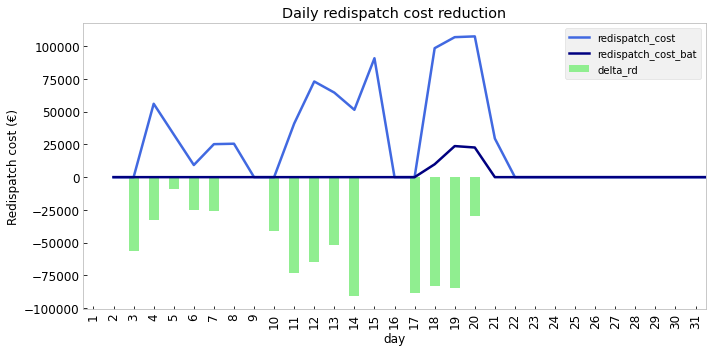

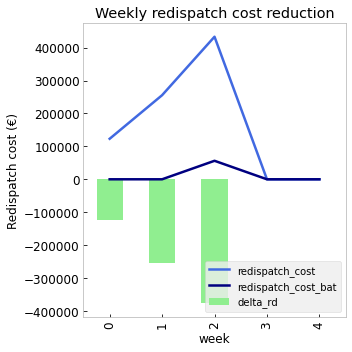

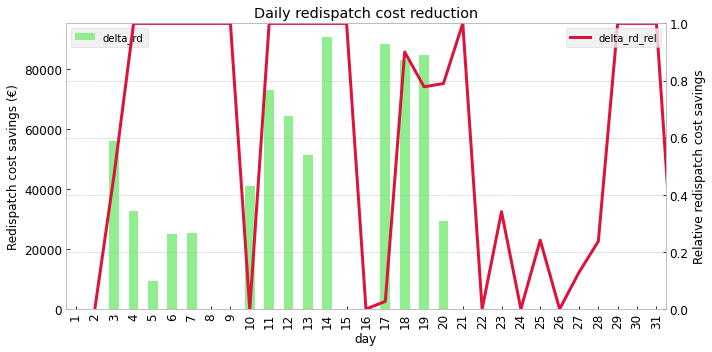

In [5]:
# Plot objective insights
# --------------
colors = ["royalblue","navy","lightgreen"]

# Redispatch cost difference per day
cols = ["redispatch_cost","redispatch_cost_bat"]
fig, ax  = plt.subplots(figsize = (10, 5))
ax.set_ylabel('Redispatch cost (€)',  fontsize = 12)
ax.set_xlabel("Time horizon (day)", fontsize = 12)
ax = df_obj_day[cols].plot.line(stacked = False, ax = ax, title = "Daily redispatch cost reduction", 
                                   color = colors, legend = True, linewidth = 2.5, fontsize = 12)
df_obj_day["delta_rd"].plot.bar(stacked = False, ax = ax, title = "Daily redispatch cost reduction", 
                                   color = "lightgreen", legend = True, width = 0.5, fontsize = 12)
ax.set_facecolor('white')
ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
ax.set_axisbelow(True)
fig.tight_layout()
plt.show()

# Redispatch cost difference per week
cols = ["redispatch_cost","redispatch_cost_bat"]
fig, ax1  = plt.subplots(figsize = (5, 5))
ax1.set_ylabel('Redispatch cost (€)',  fontsize = 12)
ax1.set_xlabel("Time horizon (week)", fontsize = 12)
ax1 = df_obj_week[cols].plot.line(stacked = False, ax = ax1, title = "Weekly redispatch cost reduction", 
                                   color = colors, legend = True, linewidth = 2.5, fontsize = 12)
df_obj_week["delta_rd"].plot.bar(stacked = False, ax = ax1, title = "Weekly redispatch cost reduction", 
                                   color = "lightgreen", legend = True, width = 0.5, fontsize = 12)
ax1.set_facecolor('white')
ax1.grid(color = 'lightgrey', linestyle = '-.', linewidth = 1.0)
ax1.set_axisbelow(True)
fig.tight_layout()
plt.show()

# Relative redispatch cost savings vs absolute savings
fig, ax2  = plt.subplots(figsize = (10, 5))
ax2.set_ylabel('Redispatch cost savings (€)',  fontsize = 12)
ax2.set_xlabel("Time horizon (day)", fontsize = 12)
ax2 = df_obj_day["delta_rd"].abs().plot.bar(stacked = False, ax = ax2, title = "Daily redispatch cost reduction", 
                                   color = ["lightgreen"], legend = True, fontsize = 12)
ax2.set_facecolor('white')
ax2.legend(loc = "upper left")
ax2.grid(color = 'gainsboro', linestyle = '-.', linewidth = 1.0)
ax2.set_axisbelow(True)

# TODO: REMOVE GRAPH OFFSET

ax2_ = ax2.twinx()
df_obj_day["delta_rd_rel"].abs().plot.line(ax = ax2_, linewidth = 3, 
                                           color = "crimson", legend = True, fontsize = 12)
ax2_.set_ylabel('Relative redispatch cost savings',  fontsize = 12)
ax2_.set_ylim(0,1.0)
fig.tight_layout()
plt.show()

### <b> Analyze redispatch costs manually per day <b>

In [6]:
# import functions to load the network 
def load_networks(import_path, filename):
    network_d = pypsa.Network(import_path + r"\dispatch\\" + filename + ".nc")
    network_rd = pypsa.Network(import_path + r"\redispatch\\" + filename + ".nc")
    network_rd_bat = pypsa.Network(import_path + r"\redispatch\\" + filename + "_bat.nc")
    return network_d, network_rd, network_rd_bat

network_d, network_rd, network_rd_bat = load_networks(import_path = r"C:\Users\Willem\pypsa-eur\networks_redispatch\results", 
                                                      filename = r"elec_s300_50_ec_lcopt_1H")

INFO:pypsa.io:Imported network elec_s300_50_ec_lcopt_1H.nc has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network elec_s300_50_ec_lcopt_1H.nc has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network elec_s300_50_ec_lcopt_1H_bat.nc has buses, carriers, generators, lines, links, loads, storage_units, stores


In [7]:
# Manual objective analysis -> redispatch cost reduction
# ---------------------
print(network_d.objective)
print(network_rd.objective)
print(network_rd_bat.objective)

# Calculate the hourly realized redispatch cost for every generator 
cols_rd = [column for column in list(network_rd.generators_t.p) if "pos" in column or "neg" in column]         
df_rd_p = network_rd.generators_t.p[cols_rd]
df_rd_p_bat = network_rd_bat.generators_t.p[cols_rd]

# positive redispatch cost
d_marg_cost = pd.Series(network_rd.generators.marginal_cost.values,index=network_rd.generators.index).to_dict()
df_ramp = df_rd_p[[column for column in list(df_rd_p) if "pos" in column]]
df_ramp_bat = df_rd_p_bat[[column for column in list(df_rd_p_bat) if "pos" in column]]
for col in list(df_ramp):
    df_ramp[col] = df_ramp[col] * d_marg_cost[col]
    df_ramp_bat[col] = df_ramp_bat [col] * d_marg_cost[col]
df_ramp_cost = df_ramp.copy()
df_ramp_cost_bat = df_ramp_bat.copy()
df_ramp_cost["sum_ramp_cost"] = df_ramp_cost.sum(axis = 1)
df_ramp_cost_bat["sum_ramp_cost_bat"] = df_ramp_cost_bat.sum(axis = 1)
# add sums
# df_ramp_cost = df_ramp_cost.append(df_ramp_cost.sum(axis = 0), ignore_index=True)
# df_ramp_cost_bat = df_ramp_cost_bat.append(df_ramp_cost_bat.sum(axis = 0), ignore_index=True)

# negative redispatch cost
df_marginal_cost = network_rd.generators_t.marginal_cost.round(2)
df_marginal_cost_bat = network_rd_bat.generators_t.marginal_cost.round(2)
df_curtail = df_rd_p[[column for column in list(df_rd_p) if "neg" in column]]
df_curtail_bat = df_rd_p_bat[[column for column in list(df_rd_p_bat) if "neg" in column]]
df_curtail_cost = df_curtail * df_marginal_cost
df_curtail_cost_bat = df_curtail_bat * df_marginal_cost_bat
# add sums
df_curtail_cost["sum_curtailment_cost"] = df_curtail_cost.sum(axis = 1)
df_curtail_cost_bat["sum_curtailment_cost_bat"] = df_curtail_cost_bat.sum(axis = 1)
# df_curtail_cost = df_curtail_cost.append(df_curtail_cost.sum(axis = 0), ignore_index=True)
# df_curtail_cost_bat = df_curtail_cost_bat.append(df_curtail_cost_bat.sum(axis = 0), ignore_index=True)


# df for comparison bat vs. no bat
df_obj = pd.concat([df_curtail_cost["sum_curtailment_cost"],
                              df_curtail_cost_bat["sum_curtailment_cost_bat"],
                              df_ramp_cost["sum_ramp_cost"], 
                              df_ramp_cost_bat["sum_ramp_cost_bat"]], axis = 1)
df_obj["redispatch_cost"] = df_obj["sum_curtailment_cost"] + df_obj["sum_ramp_cost"]
df_obj["redispatch_cost_bat"] = df_obj["sum_curtailment_cost_bat"] + df_obj["sum_ramp_cost_bat"]
df_obj["delta_ramp_cost"] = df_obj["sum_ramp_cost_bat"] - df_obj["sum_ramp_cost"]
df_obj["delta_curtailment_cost"] = df_obj["sum_curtailment_cost_bat"].round(2) - \
                                             df_obj["sum_curtailment_cost"].round(2)
df_obj["delta_rd_cost"] = df_obj["delta_curtailment_cost"] + df_obj["delta_ramp_cost"]

# create dataframe for DAILY redispatch 
df_obj_day = df_obj.groupby(np.arange(len(df_obj))//24).sum()
df_obj_day.index.rename("Time horizon (day)", inplace = True)
display(df_obj_day)

# create dataframe for WEEKLY redispatch
df_obj_week= df_obj_day.groupby(np.arange(len(df_obj_day))//7).sum()[:-1]
df_obj_week.index.rename("Time horizon (week)", inplace = True)
display(df_obj_week)

9278982771.748869
2922440.943881002
380486.0185147336


,sum_curtailment_cost,sum_curtailment_cost_bat,sum_ramp_cost,sum_ramp_cost_bat,redispatch_cost,redispatch_cost_bat,delta_ramp_cost,delta_curtailment_cost,delta_rd_cost
Time horizon (day),,,,,,,,,
0,0.0,0.0,0.000313,0.000205,0.000313,0.000205,-0.000108,0.0,-0.000108
1,0.0,0.0,0.000281,0.000000,0.000281,0.000000,-0.000281,0.0,-0.000281
2,0.0,0.0,0.000374,0.000000,0.000374,0.000000,-0.000374,0.0,-0.000374
3,0.0,0.0,0.000317,0.000000,0.000317,0.000000,-0.000317,0.0,-0.000317
4,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...
360,0.0,0.0,0.000124,0.000094,0.000124,0.000094,-0.000029,0.0,-0.000029
361,0.0,0.0,0.000015,0.000000,0.000015,0.000000,-0.000015,0.0,-0.000015
362,0.0,0.0,0.000015,0.000000,0.000015,0.000000,-0.000015,0.0,-0.000015


,sum_curtailment_cost,sum_curtailment_cost_bat,sum_ramp_cost,sum_ramp_cost_bat,redispatch_cost,redispatch_cost_bat,delta_ramp_cost,delta_curtailment_cost,delta_rd_cost
Time horizon (week),,,,,,,,,
0,0.000000,0.0,0.001710,0.000540,0.001710,0.000540,-0.001170,0.0,-0.001170
1,0.000000,0.0,0.000595,0.000000,0.000595,0.000000,-0.000595,0.0,-0.000595
2,0.000000,0.0,0.002201,0.000528,0.002201,0.000528,-0.001673,0.0,-0.001673
3,0.000000,0.0,0.001261,0.000288,0.001261,0.000288,-0.000974,0.0,-0.000974
4,0.000000,0.0,0.001498,0.000433,0.001498,0.000433,-0.001065,0.0,-0.001065
...,...,...,...,...,...,...,...,...,...
47,0.000000,0.0,554368.007230,163405.339417,554368.007230,163405.339417,-390962.667813,0.0,-390962.667813
48,-0.000045,0.0,148592.042518,0.000000,148592.042474,0.000000,-148592.042518,0.0,-148592.042518
49,0.000000,0.0,320655.692798,0.001153,320655.692798,0.001153,-320655.691646,0.0,-320655.691646


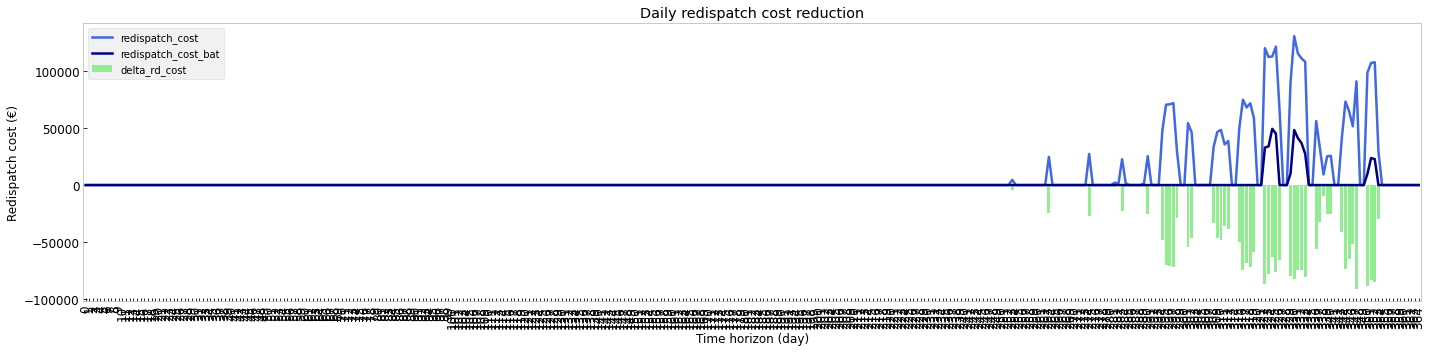

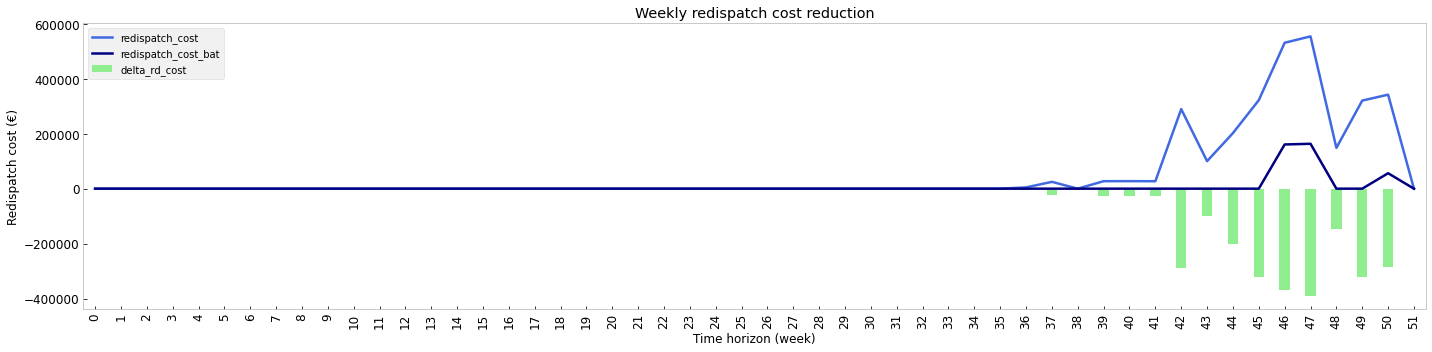

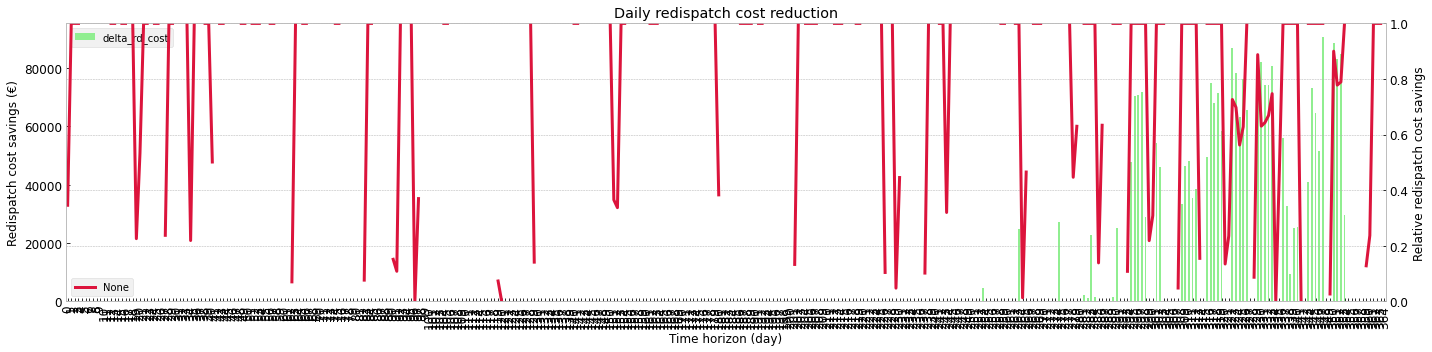

In [8]:
# Plot MANUAL objective insights
# --------------
colors = ["royalblue","navy","lightgreen"]

# Redispatch cost difference per day
cols = ["redispatch_cost","redispatch_cost_bat"]
fig, ax  = plt.subplots(figsize = (20, 5))
ax.set_ylabel('Redispatch cost (€)',  fontsize = 12)
ax.set_xlabel("Time horizon (day)", fontsize = 12)
ax = df_obj_day[cols].plot.line(stacked = False, ax = ax, title = "Daily redispatch cost reduction", 
                                   color = colors, legend = True, linewidth = 2.5, fontsize = 12)
df_obj_day["delta_rd_cost"].plot.bar(stacked = False, ax = ax, title = "Daily redispatch cost reduction", 
                                   color = "lightgreen", legend = True, width = 0.8, fontsize = 12)
ax.set_facecolor('white')
ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
ax.set_axisbelow(True)
fig.tight_layout()
plt.show()

# Redispatch cost difference per week
cols = ["redispatch_cost","redispatch_cost_bat"]
fig, ax1  = plt.subplots(figsize = (20, 5))
ax1.set_ylabel('Redispatch cost (€)',  fontsize = 12)
ax1.set_xlabel("Time horizon (week)", fontsize = 12)
ax1 = df_obj_week[cols].plot.line(stacked = False, ax = ax1, title = "Weekly redispatch cost reduction", 
                                   color = colors, legend = True, linewidth = 2.5, fontsize = 12)
df_obj_week["delta_rd_cost"].plot.bar(stacked = False, ax = ax1, title = "Weekly redispatch cost reduction", 
                                   color = "lightgreen", legend = True, width = 0.4, fontsize = 12)
ax1.set_facecolor('white')
ax1.grid(color = 'lightgrey', linestyle = '-.', linewidth = 1.0)
ax1.set_axisbelow(True)
fig.tight_layout()
plt.show()

# Relative redispatch cost savings vs absolute savings
fig, ax2  = plt.subplots(figsize = (20, 5))
ax2.set_ylabel('Redispatch cost savings (€)',  fontsize = 12)
ax2.set_xlabel("Time horizon (day)", fontsize = 12)
ax2 = df_obj_day["delta_rd_cost"].abs().plot.bar(stacked = False, ax = ax2, title = "Daily redispatch cost reduction", 
                                   color = ["lightgreen"], legend = True, fontsize = 12)
ax2.set_facecolor('white')
ax2.legend(loc = "upper left")
ax2.grid(color = 'gainsboro', linestyle = '-.', linewidth = 1.0)
ax2.set_axisbelow(True)

# TODO: REMOVE GRAPH OFFSET

ax2_ = ax2.twinx()
(df_obj_day["delta_rd_cost"] / df_obj_day["redispatch_cost"]).abs().plot.line(ax = ax2_, linewidth = 3, 
                                           color = "crimson", legend = True, fontsize = 12)
ax2_.set_ylabel('Relative redispatch cost savings',  fontsize = 12)
ax2_.set_ylim(0,1.0)
fig.tight_layout()
plt.show()

name,Negative redispatch,Positive redispatch,Negative redispatch bat,Positive redispatch bat,Difference in curtailment,Difference in ramp-up,Total redispatch,Total redispatch bat,Total redispatch difference
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
...,...,...,...,...,...,...,...,...,...
8756,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
8757,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
8758,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
8759,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00


,Total redispatch,delta_rd_cost
Time horizon (day),,
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
360,0.0,0.0
361,0.0,0.0
362,0.0,0.0


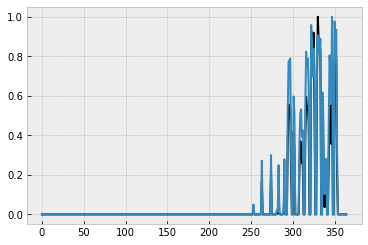

<AxesSubplot:>

In [9]:

# Reduction of redispatch energy (positive and negative)
# ---------------

# Redispatch power dataframe
cols_rd = [column for column in list(network_rd.generators_t.p) if "pos" in column or "neg" in column]         
df_rd_p = network_rd.generators_t.p[cols_rd]
df_rd_p_bat = network_rd_bat.generators_t.p[cols_rd]
# sum of positive redispatch
cols_pos = [column for column in list(df_rd_p) if "pos" in column]
df_rd_p["Positive redispatch"] = df_rd_p.loc[:,cols_pos].sum(axis = 1)
df_rd_p_bat["Positive redispatch bat"] = df_rd_p_bat.loc[:,cols_pos].sum(axis = 1)
# sum of negative redispatch
cols_neg = [column for column in list(df_rd_p_bat) if "neg" in column]
df_rd_p["Negative redispatch"] = df_rd_p.loc[:,cols_neg].sum(axis = 1)
df_rd_p_bat["Negative redispatch bat"] = df_rd_p_bat.loc[:,cols_neg].sum(axis = 1)

# Difference of redispatch (pos/neg) and total redispatch datarame
df_bat_nobat = pd.concat([df_rd_p[["Negative redispatch", "Positive redispatch"]], 
                             df_rd_p_bat[["Negative redispatch bat", "Positive redispatch bat"]]], 
                            axis = 1)

# differences in redispatch bat vs no bat
df_bat_nobat = df_bat_nobat.round(2)
df_bat_nobat["Difference in curtailment"] = df_bat_nobat.iloc[:,2] - df_bat_nobat.iloc[:,0]
df_bat_nobat["Difference in ramp-up"] = df_bat_nobat.iloc[:,3] - df_bat_nobat.iloc[:,1]
df_bat_nobat["Total redispatch"] = abs(df_bat_nobat["Negative redispatch"]) + abs(df_bat_nobat["Positive redispatch"])
df_bat_nobat["Total redispatch bat"] = abs(df_bat_nobat["Negative redispatch bat"]) + abs(df_bat_nobat["Positive redispatch bat"])
df_bat_nobat["Total redispatch difference"] = df_bat_nobat["Total redispatch bat"] - df_bat_nobat["Total redispatch"]
df_bat_nobat.index.rename("Time horizon (hour)", inplace = True)
df_bat_nobat = df_bat_nobat.append(df_bat_nobat.sum(axis = 0), ignore_index = True)

display(df_bat_nobat)
# Analyze: are the days of most cost reduction also the days of most redispatch power in the no_bat scenario?
# --------------

def get_dtw_diff_matrix(cols:list):
    """
    From a list of column names referring to a pandas dataframe with series as columns, compute a distance matrix by computing the 
    DTW distance of all pairwise combinations of series. I take the column names as input so it does reduce the complexity when indexing.
    """
    diff_matrix = {}
    cross = itertools.product(cols, cols)
    for (col1, col2) in cross:
        series1 = df_dtw[col1]
        series2 = df_dtw[col2]
        #print(series1,series2)
        # measure difference dtw
        diff = dtw(series1, 
                   series2, 
                   keep_internals=True, 
                   step_pattern=rabinerJuangStepPattern(2, "c")).normalizedDistance
        diff_matrix[(col1 , col2)] = [diff]
    # convert to pandas dataframe    
    dtw_diff_df = pd.DataFrame(diff_matrix).T.reset_index()\
      .rename(columns = {"level_0":"Delta_obj_day", "level_1":"Total redispatch", 0:"diff"})\
      .pivot_table(index = "Delta_obj_day", columns = "Total redispatch", values = "diff")
    return dtw_diff_df



# Create dtw dataframe and scale it so that dynamic time warping can be applied
df_bat_nobat_day = df_bat_nobat.iloc[:-1].groupby(np.arange(len(df_obj))//24).sum()
df_bat_nobat_day.index.rename("Time horizon (day)", inplace = True)
df_dtw = pd.concat([df_bat_nobat_day["Total redispatch"], - df_obj_day["delta_rd_cost"]], axis = 1).round(2)
df_dtw[df_dtw == -0.0] = 0
scaler = MinMaxScaler()
df_dtw[["Total redispatch","delta_rd_cost"]] = scaler.fit_transform(df_dtw[["Total redispatch","delta_rd_cost"]])
dtw_diff = dtw(df_dtw.iloc[:, 0], df_dtw.iloc[:, 1], keep_internals=True, 
               step_pattern=rabinerJuangStepPattern(2, "b"))

display(df_dtw)
dtw_diff.plot(type="twoway")





#### TODO: CHECK WHETHER POSITIVE AND NEGATIVE POWER STATS ARE CORRECT



# # Dispatch time series
# df_dispatch_t = network.generators_t.p.copy()
# df_dispatch_t["Sum"] = df_dispatch_t.sum(axis = 1)

In [ ]:
# Plots of objective and redispatch power reduction
# ------------

# Plot difference in redispatch energy
cols = ["Negative redispatch","Positive redispatch"]
fig, ax  = plt.subplots(figsize = (15, 8))
ax.set_ylabel('Total hourly redispatch (MW)',  fontsize = 12)
ax.set_xlabel("Time horizon (hour)", fontsize = 12)
ax = df_bat_nobat[cols].iloc[:-1].plot.line(stacked = False, ax = ax, title = "Hourly redispatch power comparison", 
                                   color = colors, legend = True, linewidth = 1.2, fontsize = 12)
ax.set_facecolor('white')
ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
ax.set_axisbelow(True)
fig.tight_layout()
plt.show()

In [ ]:
# ---------------
# Extract results from dispatch & redispatch optimization
#
# Analysis:

# - reduction of line overloading (time with line cap. at 100%)
# - change in merit order dispatch -> redispatch: merit order plotten dispatch vs. redispatch mit und ohne batterien (an beispielhaften
#   tagen mit besonders hoher, mittlerer, und geringer last)
#
# Retionalization of analysis
# - reduction of ramp up/down at specific locations (locations = groups of buses (by their name/number) especially in the north as well as the south)
# - most overloaded lines (lines at 100% capacity), buses with most redispatch energy

In [ ]:
# CO2 ANALYSIS
# ------------

def map_values(row, values_dict):
    return values_dict[row]

# W/o bat
df_gen = network_rd.generators.copy()
dict_co2 = pd.Series(network_rd.carriers["co2_emissions"].values,index=network_rd.carriers.index).to_dict()
df_gen["co2_emissions"] = df_gen["carrier"].apply(map_values, args = (dict_co2,)) 

dict_co2_gen = pd.Series(df_gen["co2_emissions"].values,index=df_gen.index).to_dict()
cols_rd = [column for column in list(network_rd.generators_t.p) if "pos" in column or "neg" in column]
df_rd_p = network_rd.generators_t.p[cols_rd].copy()
# assign co2 emissions to the redispatch energy dataframe
for col in list(df_rd_p):
    if "pos" in col: # if positive redispatch: co2 emission
        df_rd_p[col] = df_rd_p[col] * dict_co2_gen[col]
    else: # co2 reduction
        df_rd_p[col] = df_rd_p[col] * dict_co2_gen[col]
df_rd_p["co2_sum"] = df_rd_p.sum(axis = 1)
df_rd_p.index.rename("Time horizon (hour)", inplace = True)

# With Bat
df_gen_bat = network_rd_bat.generators.copy()
dict_co2 = pd.Series(network_rd_bat.carriers["co2_emissions"].values,index=network_rd_bat.carriers.index).to_dict()
df_gen_bat["co2_emissions"] = df_gen_bat["carrier"].apply(map_values, args = (dict_co2,))
dict_co2_gen = pd.Series(df_gen_bat["co2_emissions"].values,index=df_gen_bat.index).to_dict()
cols_rd = [column for column in list(network_rd_bat.generators_t.p) if "pos" in column or "neg" in column]
df_rd_p_bat = network_rd_bat.generators_t.p[cols_rd].copy()
# assign co2 emissions to the redispatch energy dataframe
for col in list(df_rd_p_bat):
    if "pos" in col: # if positive redispatch: co2 emission
        df_rd_p_bat[col] = df_rd_p_bat[col] * dict_co2_gen[col]
    else: # co2 reduction
        df_rd_p_bat[col] = df_rd_p_bat[col] * dict_co2_gen[col]
df_rd_p_bat["co2_sum_bat"] = df_rd_p_bat.sum(axis = 1)
df_rd_p_bat.index.rename("Time horizon (hour)", inplace = True)

# Df for direct co2 comparison
df_bat_nobat = pd.concat([df_rd_p["co2_sum"], df_rd_p_bat["co2_sum_bat"]], axis = 1)
df_bat_nobat["co2_difference"] = df_bat_nobat["co2_sum_bat"] - df_bat_nobat["co2_sum"]
df_bat_nobat.index.rename("Time horizon (hour)", inplace = True)
display(df_bat_nobat)

# Df for daily co2 comparison
df_co2_day = df_bat_nobat.groupby(np.arange(len(df_rd_diff_wind.iloc[:-1]))//24).sum()


# Wind curtailment analysis -> reduction in wind curtailment
# -------------
df_rd_p = network_rd.generators_t.p[cols_rd].copy()
df_rd_p_bat = network_rd_bat.generators_t.p[cols_rd].copy()
cols_wind = [column for column in list(df_rd_p) if "wind" in column]
df_rd_wind = df_rd_p[cols_wind]
df_rd_bat_wind = df_rd_p_bat[cols_wind]
df_rd_diff_wind = df_rd_bat_wind - df_rd_wind # < 0 more curtailment > 0 less curtailment
df_rd_diff_wind["sum_diff_curtailment"] = df_rd_diff_wind.sum(axis = 1)
# add row with curtailment sums
df_rd_diff_wind = df_rd_diff_wind.append(df_rd_diff_wind.sum(axis = 0), ignore_index=True)

# DAILY wind curtailment analysis
df_rd_diff_wind_day = df_rd_diff_wind.iloc[:-1].groupby(np.arange(len(df_rd_diff_wind.iloc[:-1]))//24).sum()
df_rd_diff_wind_day.index.rename("Time horizon (day)", inplace = True)
display(df_rd_diff_wind_day)
# WEEKLY wind curtailment analysis
df_rd_diff_wind_week = df_rd_diff_wind_day.groupby(np.arange(len(df_rd_diff_wind_day))//7).sum()[:-1]
df_rd_diff_wind_week.index.rename("Time horizon (week)", inplace = True)
display(df_rd_diff_wind_week)


# Conventional analysis -> reduction in conventional ramp up
# -------------
df_rd_p = network_rd.generators_t.p[cols_rd].copy()
df_rd_p_bat = network_rd_bat.generators_t.p[cols_rd].copy()
cols_pos = [column for column in list(df_rd_p) if "pos" in column]
df_ramp_p = df_rd_p[cols_pos]
df_ramp_p_bat = df_rd_p_bat[cols_pos]
# Only extract columns with conventional carriers 
cols_gas = [column for column in list(df_ramp_p) if "CCGT" in column or "OCGT" in column]
cols_oil = [column for column in list(df_ramp_p) if "oil" in column]
cols_lignite = [column for column in list(df_ramp_p) if "lignite" in column]
cols_nuclear = [column for column in list(df_ramp_p) if "nuclear" in column]
cols_coal = [column for column in list(df_ramp_p) if "coal" in column]
cols_conv = cols_gas + cols_oil + cols_lignite + cols_nuclear + cols_coal + cols_coal
df_ramp_conv = df_ramp_p[cols_conv]
df_ramp_conv_bat = df_ramp_p_bat[cols_conv]
df_ramp_diff_conv = df_ramp_conv_bat - df_ramp_conv # < 0 less ramp up > 0 more ramp up
df_ramp_diff_conv["sum_diff_ramp_up"] = df_ramp_diff_conv.sum(axis = 1)
# column for sums of diff per energy carrier
df_ramp_diff_conv["gas_diff_ramp_up"] = df_ramp_diff_conv[cols_gas].sum(axis = 1)
df_ramp_diff_conv["oil_diff_ramp_up"] = df_ramp_diff_conv[cols_oil].sum(axis = 1)
df_ramp_diff_conv["lignite_diff_ramp_up"] = df_ramp_diff_conv[cols_lignite].sum(axis = 1)
df_ramp_diff_conv["nuclear_diff_ramp_up"] = df_ramp_diff_conv[cols_nuclear].sum(axis = 1)
df_ramp_diff_conv["coal_diff_ramp_up"] = df_ramp_diff_conv[cols_coal].sum(axis = 1)
# add row with ramp up sums 
df_ramp_diff_conv = df_ramp_diff_conv.append(df_ramp_diff_conv.sum(axis = 0), ignore_index=True)

# DAILY wind curtailment analysis
df_ramp_diff_conv_day = df_ramp_diff_conv.iloc[:-1].groupby(np.arange(len(df_ramp_diff_conv.iloc[:-1]))//24).sum()
df_ramp_diff_conv_day.index.rename("Time horizon (day)", inplace = True)
display(df_ramp_diff_conv_day)
# WEEKLY wind curtailment analysis
df_ramp_diff_conv_week = df_ramp_diff_conv_day.groupby(np.arange(len(df_ramp_diff_conv_day))//7).sum()[:-1]
df_ramp_diff_conv_week.index.rename("Time horizon (week)", inplace = True)
display(df_ramp_diff_conv_week)

display(df_ramp_diff_conv)

In [ ]:
# Plot Co2 insights
# --------------
colors = ["navy","green","lightgreen"]

# CO2 balance with bat vs. w/o bat
cols = ["co2_sum","co2_sum_bat"]
fig, ax  = plt.subplots(figsize = (30, 8))
ax.set_ylabel('CO2 balance of redispatch',  fontsize = 12)
ax.set_xlabel("Time horizon (hour)", fontsize = 12)
ax = df_bat_nobat[cols].plot.line(stacked = False, ax = ax, title = "Hourly Co2 balance of redispatch operations", 
                                   color = colors, legend = True, linewidth = 1.2, fontsize = 12)
ax.set_facecolor('white')
ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
ax.set_axisbelow(True)
fig.tight_layout()
plt.show()

# CO2 balance with bat
cols = ["co2_sum_bat"]
fig, ax  = plt.subplots(figsize = (30, 8))
ax.set_ylabel('CO2 balance of redispatch',  fontsize = 12)
ax.set_xlabel("Time horizon (hour)", fontsize = 12)
ax = df_bat_nobat[cols].plot.line(stacked = False, ax = ax, title = "Hourly Co2 balance of redispatch operations", 
                                   color = "green", legend = True, linewidth = 1.2, fontsize = 12)
ax.set_facecolor('white')
ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
ax.set_axisbelow(True)
fig.tight_layout()
plt.show()

# Differences in CO2 balances bat vs. no bat 
cols = ["co2_difference"]
fig, ax  = plt.subplots(figsize = (30, 10))
ax.set_ylabel('CO2 balance of redispatch',  fontsize = 12)
ax.set_xlabel("Time horizon (hour)", fontsize = 12)
ax = df_bat_nobat["co2_difference"].where(df_bat_nobat["co2_difference"].ge(0), 0).plot.line(stacked = False, ax = ax, title = "Hourly Co2 balance of redispatch operations", 
                                   color = "red", legend = True, linewidth = 1.2, fontsize = 12)
df_bat_nobat["co2_difference"].where(df_bat_nobat["co2_difference"].lt(0), 0).plot.line(ax = ax, color = "green")
ax.set_facecolor('white')
ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
ax.set_axisbelow(True)
fig.tight_layout()
plt.show()

# Differences in conventional ramp up (without sum row) HOURLY
cols = ["sum_diff_ramp_up"]
fig, ax  = plt.subplots(figsize = (30, 10))
ax.set_ylabel('Difference in conventional ramp up',  fontsize = 12)
ax.set_xlabel("Time horizon (hour)", fontsize = 12)
ax = df_ramp_diff_conv["sum_diff_ramp_up"].iloc[:-1].where(df_ramp_diff_conv["sum_diff_ramp_up"].iloc[:-1].ge(0), 0)\
.plot.line(stacked = False, ax = ax, title = "Hourly conventional ramp up", 
           color = "red", legend = True, linewidth = 1.2, fontsize = 12)
df_ramp_diff_conv["sum_diff_ramp_up"].iloc[:-1].where(df_ramp_diff_conv["sum_diff_ramp_up"].iloc[:-1].lt(0), 0).plot.line(ax = ax, color = "green")
ax.set_facecolor('white')
ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
ax.set_axisbelow(True)
fig.tight_layout()
plt.show()

# Differences in conventional ramp up (without sum row) DAILY
fig, ax  = plt.subplots(figsize = (30, 10))
ax.set_ylabel('Difference in conventional ramp up',  fontsize = 12)
ax.set_xlabel("Time horizon (hour)", fontsize = 12)
ax = df_ramp_diff_conv_day["sum_diff_ramp_up"].iloc[:-1].where(df_ramp_diff_conv_day["sum_diff_ramp_up"].ge(0), 0)\
.plot.line(stacked = False, ax = ax, title = "Hourly conventional ramp up", 
           color = "red", legend = True, linewidth = 1.2, fontsize = 12)
df_ramp_diff_conv_day["sum_diff_ramp_up"].where(df_ramp_diff_conv_day["sum_diff_ramp_up"].lt(0), 0).plot.line(ax = ax, color = "green")
ax.set_facecolor('white')
ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
ax.set_axisbelow(True)
fig.tight_layout()
plt.show()

# Differences in conventional ramp up (without sum row) WEEKLY
fig, ax  = plt.subplots(figsize = (30, 10))
ax.set_ylabel('Difference in conventional ramp up',  fontsize = 12)
ax.set_xlabel("Time horizon (hour)", fontsize = 12)
ax = df_ramp_diff_conv_week["sum_diff_ramp_up"].iloc[:-1].where(df_ramp_diff_conv_week["sum_diff_ramp_up"].ge(0), 0)\
.plot.line(stacked = False, ax = ax, title = "Hourly conventional ramp up", 
           color = "red", legend = True, linewidth = 1.2, fontsize = 12)
df_ramp_diff_conv_week["sum_diff_ramp_up"].where(df_ramp_diff_conv_week["sum_diff_ramp_up"].lt(0), 0).plot.line(ax = ax, color = "green")
ax.set_facecolor('white')
ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
ax.set_axisbelow(True)
fig.tight_layout()
plt.show()

# Difference in wind curtailment
cols = ["sum_diff_curtailment"]
fig, ax  = plt.subplots(figsize = (30, 10))
ax.set_ylabel('Difference in wind curtailment',  fontsize = 12)
ax.set_xlabel("Time horizon (hour)", fontsize = 12)
ax = df_rd_diff_wind["sum_diff_curtailment"].iloc[:-1].where(df_rd_diff_wind["sum_diff_curtailment"].iloc[:-1].ge(0), np.NaN)\
.plot.line(stacked = False, ax = ax, title = "Hourly conventional ramp up", 
           color = "red", legend = True, linewidth = 1.2, fontsize = 12)
df_rd_diff_wind["sum_diff_curtailment"].iloc[:-1].where(df_rd_diff_wind["sum_diff_curtailment"].iloc[:-1].lt(0), np.NaN).plot.line(ax = ax, color = "green")
ax.set_facecolor('white')
ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
ax.set_axisbelow(True)
fig.tight_layout()
plt.show()

In [ ]:
# Extract results from dispatch & redispatch optimization



# cost reduction
delta_objective = network_rd.objective - network_rd_bat.objective
print(round(delta_objective, 2))

# Dispatch time series
df_dispatch_t = network.generators_t.p.copy()
df_dispatch_t["Sum"] = df_dispatch_t.sum(axis = 1)

# Redispatch w/o batteries
# ------------------------

# Redispatch df
df_redispatch_t = network_rd.generators_t.p.copy()
cols_rd = [column for column in list(df_redispatch_t) if "pos" in column or "neg" in column]         
df_redispatch_t = df_redispatch_t.copy()[cols_rd]

# Resulting dispatch after redispatch
#display(df_redispatch_t)

# Absolute redispatch df
df_redispatch_abs = df_redispatch_t.abs()
df_redispatch_abs["Sum"] = df_redispatch_abs.sum(axis = 1)

# df for positive rd
cols_rd_pos = [column for column in list(df_redispatch_t) if "pos" in column]         
df_redispatch_t_pos = df_redispatch_t.copy()[cols_rd_pos]
df_redispatch_t_pos["Sum pos"] = df_redispatch_t_pos.sum(axis = 1)

# df for negative rd
cols_rd_neg = [column for column in list(df_redispatch_t) if "neg" in column]         
df_redispatch_t_neg = df_redispatch_t.copy()[cols_rd_neg]
df_redispatch_t_neg["Sum neg"] = df_redispatch_t_neg.sum(axis = 1)

# Add sums to redispatch df
df_redispatch_t["Sum pos"] = df_redispatch_t_pos["Sum pos"]
df_redispatch_t["Sum neg"] = df_redispatch_t_neg["Sum neg"]


# Redispatch w/ batteries
# ------------------------

# Redispatch time series with batteries
df_redispatch_t_bat = network_rd_bat.generators_t.p.copy()
cols_rd = [column for column in list(df_redispatch_t_bat) if "pos" in column or "neg" in column]         
df_redispatch_t_bat = df_redispatch_t_bat[cols_rd].copy()

# Absolute redispatch df
df_redispatch_abs = df_redispatch_t_bat.abs()
df_redispatch_abs["Sum"] = df_redispatch_abs.sum(axis = 1)

# df for positive rd
cols_rd_pos = [column for column in list(df_redispatch_t_bat) if "pos" in column]         
df_redispatch_t_bat_pos = df_redispatch_t_bat.copy()[cols_rd_pos]
df_redispatch_t_bat_pos["Sum pos"] = df_redispatch_t_bat_pos.sum(axis = 1)

# df for negative rd
cols_rd_neg = [column for column in list(df_redispatch_t_bat) if "neg" in column]         
df_redispatch_t_bat_neg = df_redispatch_t_bat.copy()[cols_rd_neg]
df_redispatch_t_bat_neg["Sum neg"] = df_redispatch_t_bat_neg.sum(axis = 1)

# Add sums to redispatch df
df_redispatch_t_bat["Sum pos"] = df_redispatch_t_bat_pos["Sum pos"]
df_redispatch_t_bat["Sum neg"] = df_redispatch_t_bat_neg["Sum neg"]

# df with difference of redispatch
df_bat_vs_nobat = pd.concat([df_redispatch_t[["Sum pos", "Sum neg"]], df_redispatch_t_bat[["Sum pos", "Sum neg"]]], axis = 1)
df_bat_vs_nobat["Difference positive"] = abs(df_bat_vs_nobat.iloc[:,0] - df_bat_vs_nobat.iloc[:,2])
df_bat_vs_nobat["Difference negative"] = - abs(df_bat_vs_nobat.iloc[:,1] - df_bat_vs_nobat.iloc[:,3])
#display(df_bat_vs_nobat)

# battery charging operations (of one in the north and one in the south)
df_bess = network_rd_bat.stores
df_bess_t_p = network_rd_bat.stores_t.p

display(network_rd_bat.stores_t.p)
display(network_rd_bat.stores_t.e)
display(network_rd_bat.stores.e_nom.T)
df_bess_SOC = network_rd_bat.stores_t.e / network_rd_bat.stores.e_nom.T
print("df_bess_SOC")
display(df_bess_SOC)






### Backup Code (Ältere Versionen)

In [ ]:
# RUN THE MODEL
# ----------------

# import both the operative network (n) as well as the optimized investment network n_optim
n = pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\elec_s300_16_ec_lcopt_1H.nc")
n_optim = pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\solved\elec_s300_16_ec_lcopt_1H.nc")

filepath = r"C:\Users\Willem\pypsa-eur\networks_redispatch\solved\elec_s300_16_ec_lcopt_1H.nc"

for c in n_optim.iterate_components(list(n.components.keys())[2:]):
    print("{} has {} entries".format(c.name,len(c.df)))
    
for c in n.iterate_components(list(n.components.keys())[2:]):
    print("{} has {} entries".format(c.name,len(c.df)))  

# Run the redispatch workflow with batteries
nw = n.copy(snapshots = network.snapshots[0:24*7])
nw_optim = n_optim.copy(snapshots = network.snapshots[0:24*7])

export_path = r"C:\Users\Willem\pypsa-eur\networks_redispatch\results"

n_d, n_rd, dict_obj_d, dict_obj_rd = redispatch_workflow(nw, nw_optim, scenario = "no bat")
n_d.export_to_netcdf(path= export_path + "\dispatch\{}".format(filepath.split('\\')[-1]),
                     export_standard_types=False, least_significant_digit=None)
# export network as .nc



In [ ]:
# ------------------------
# Plots w/o bat
# ------------------------

# # Dispatch time series
# cols = list(df_dispatch_t)[:-1]
# fig, ax  = plt.subplots(figsize = (10, 5))
# ax.set_ylabel('MW Redispatch',  fontsize = 12)
# ax = df_dispatch_t.loc[:, cols].plot.bar(stacked = True, ax = ax, title = "Dispatch after market clearing", legend = True, fontsize = 12)
# ax.set_facecolor('white')
# ax.grid(color = 'grey', linestyle = '-.', linewidth = 1.0)

# # Redispatch time series (pos vs. neg aggregate) 
# cols_0 = list(df_redispatch_t)[-2:]
# fig, ax_0  = plt.subplots(figsize = (10, 5))
# ax_0.set_ylabel('MW Redispatch',  fontsize = 12)
# ax_0 = df_redispatch_t.loc[:, cols_0].plot.bar(stacked = True, ax = ax_0, title = "Amount of redispatch", legend = True, fontsize = 12)
# ax_0.set_facecolor('white')
# ax_0.grid(color = 'grey', linestyle = '-.', linewidth = 1.0)

# # Redispatch time series (aggregate) 
# cols_1 = list(df_redispatch_abs)[:-1]
# fig, ax_1  = plt.subplots(figsize = (10, 5))
# ax_1.set_ylabel('MW Redispatch',  fontsize = 12)
# ax_1 = df_redispatch_abs.loc[:, cols_1].plot.bar(stacked = True, ax = ax_1, title = "Aggregated amount of redispatch", legend = True, fontsize = 12)
# ax_1.set_facecolor('white')
# ax_1.grid(color = 'grey', linestyle = '-.', linewidth = 1.0)

# # Redispatch time series (positive rd) 
# cols_2 = list(df_redispatch_t_pos)[:-1]
# fig, ax_2  = plt.subplots(figsize = (10, 5))
# ax_2.set_ylabel('MW Redispatch',  fontsize = 12)
# ax_2 = df_redispatch_t_pos.loc[:, cols_2].plot.bar(stacked = True, ax = ax_2, title = "Amount of positive redispatch (ramp up)", legend = True, fontsize = 12)
# ax_2.set_facecolor('white')
# ax_2.grid(color = 'grey', linestyle = '-.', linewidth = 1.0)

# # Redispatch time series (negative rd) 
# cols_3 = list(df_redispatch_t_neg)[:-1]
# fig, ax_3  = plt.subplots(figsize = (10, 5))
# ax_3.set_ylabel('MW Redispatch',  fontsize = 12)
# ax_3 = df_redispatch_t_neg.loc[:, cols_3].plot.bar(stacked = True, ax = ax_3, title = "Amount of negative redispatch (curtailment)", legend = True, fontsize = 12)
# ax_3.set_facecolor('white')
# ax_3.grid(color = 'grey', linestyle = '-.', linewidth = 1.0)

# # Plots w/ bat
# # ------------------------

# Redispatch time series (pos vs. neg aggregate) 
cols_4 = list(df_redispatch_t_bat)[-2:]
fig, ax_4  = plt.subplots(figsize = (10, 5))
ax_4.set_ylabel('MW Redispatch',  fontsize = 12)
ax_4 = df_redispatch_t_bat.loc[:, cols_4].plot.bar(stacked = True, ax = ax_4, title = "Amount of positive and negative redispatch", legend = True, fontsize = 12)
ax_4.set_facecolor('white')
ax_4.grid(color = 'grey', linestyle = '-.', linewidth = 1.0)

# Difference positive vs negative redispatch 
cols_5 = list(df_bat_vs_nobat)[-2:]
fig, ax_5  = plt.subplots(figsize = (10, 5))
ax_5.set_ylabel('MW Redispatch',  fontsize = 12)
ax_5 = df_bat_vs_nobat.loc[:, cols_5].plot.bar(stacked = True, ax = ax_5, title = "Difference between redispatch with and without bat", legend = True, fontsize = 12)
ax_5.set_facecolor('white')
ax_5.grid(color = 'grey', linestyle = '-.', linewidth = 1.0)

# Plots battery insights
# ------------------------

# Battery charging operations (battery in the north)
cols_6 = ["BESS_1","BESS_2","BESS_3"]
fig, ax_6  = plt.subplots(figsize = (10, 5))
ax_6.set_ylabel('MW Redispatch',  fontsize = 12)
ax_6 = df_bess_t_p.loc[:, cols_6].plot.bar(stacked = True, ax = ax_6, title = "Battery active power in redispatch", legend = True, fontsize = 12)
ax_6.set_facecolor('white')
ax_6.grid(color = 'grey', linestyle = '-.', linewidth = 1.0)

# Battery SOC
cols_7 = ["BESS_1","BESS_2","BESS_3"]
fig, ax_7  = plt.subplots(figsize = (10, 5))
ax_7.set_ylabel('Battery SOC',  fontsize = 12)
ax_7 = df_bess_SOC.loc[:, cols_7].plot.line(stacked = False, ax = ax_7, title = "Battery SOC during redispatch", legend = True, fontsize = 12)
ax_7.set_facecolor('white')
ax_7.grid(color = 'grey', linestyle = '-.', linewidth = 1.0)
                   

        
    


In [ ]:
def set_parameters_from_optimized(n, n_optim):
    '''
    Function to set optimized parameters from optimized network as nominal parameters
    of the operative network.
    -----
    Param:
    n: Optimized investment network.
    n_optim: Operative network for redispatch simulation.
    '''
    # set line capacities to optimized
    lines_typed_i = n.lines.index[n.lines.type != '']
    n.lines.loc[lines_typed_i, 'num_parallel'] = \
        n_optim.lines['num_parallel'].reindex(lines_typed_i, fill_value=0.)
    n.lines.loc[lines_typed_i, 's_nom'] = (
            np.sqrt(3) * n.lines['type'].map(n.line_types.i_nom) *
            n.lines.bus0.map(n.buses.v_nom) * n.lines.num_parallel)

    lines_untyped_i = n.lines.index[n.lines.type == '']
    for attr in ('s_nom', 'r', 'x'):
        n.lines.loc[lines_untyped_i, attr] = \
            n_optim.lines[attr].reindex(lines_untyped_i, fill_value=0.)
    n.lines['s_nom_extendable'] = False

    # set link capacities to optimized (HVDC links as well as store out/inflow links)
    links_dc_i = n.links.index[n.links.carrier == 'DC']
    n.links.loc[links_dc_i, 'p_nom'] = \
        n_optim.links['p_nom_opt'].reindex(links_dc_i, fill_value=0.)
    n.links.loc[links_dc_i, 'p_nom_extendable'] = False

    # set extendable generators to optimized and p_nom_extendable to False
    gen_extend_i = n.generators.index[n.generators.p_nom_extendable]
    n.generators.loc[gen_extend_i, 'p_nom'] = \
        n_optim.generators['p_nom_opt'].reindex(gen_extend_i, fill_value=0.)
    n.generators.loc[gen_extend_i, 'p_nom_extendable'] = False

    # set extendable storage unit power to ooptimized
    stor_extend_i = n.storage_units.index[n.storage_units.p_nom_extendable]
    n.storage_units.loc[stor_extend_i, 'p_nom'] = \
        n_optim.storage_units['p_nom_opt'].reindex(stor_extend_i, fill_value=0.)
    n.storage_units.loc[stor_extend_i, 'p_nom_extendable'] = False
    return n


def print_lopf_insights(network):
    # generator power
    print(" \nGenerator active power per snapshot:")
    print(network.generators_t.p)

    # network line flows
    print(" \nLine active power per snapshot:")
    print(network.lines_t.p0)

    # relative line loading
    print(" \nRelative line loading per snapshot:")
    print(abs(network.lines_t.p0) / network.lines.s_nom)
    max_loading = (network.lines_t.p0 / network.lines.s_nom).max(axis=0)
    print(max_loading)

    # In linear approximation, all voltage magnitudes are nominal, i.e. 1 per unit
    print(" \nVoltage magnitude at nodes:")
    print(network.buses_t.v_mag_pu)

    # At bus 2 the price is set above any marginal generation costs in the model, because to dispatch to
    # it from expensive generator 0, also some dispatch from cheap generator 1 has to be substituted from generator0
    # to avoid overloading line 1.
    print(" \nMarginal prices at nodes:")
    print(network.buses_t.marginal_price)


def clean_batteries(network):
    """
    Clean up all previously saved battery components (FROM PYPSA-EUR) related to redispatch (does NOT delete the inital batteries)
    """
    network.mremove("StorageUnit", [name for name in network.storage_units.index.tolist()
                                    if network.storage_units.loc[name]["carrier"] == "battery"])
    network.mremove("Link", [name for name in network.links.index.tolist()
                             if "BESS" in name])
    network.mremove("Store", [name for name in network.stores.index.tolist()
                              if "BESS" in name])
    network.mremove("Bus", [name for name in network.buses.index.tolist()
                            if "BESS" in name])


def add_BESS_loadflexibility(network, network_year, flex_potential=10000, c_rate=0.25, flex_share=0.1):
    '''
    Adds battery storages at every node, depending on the flexibility potential of the loads allocated to this node.
    Methodology according to Network development plan and Frontier study:
        - Flexibility potential at load-nodes: Flexibility Potential through stationary battery storage in distribution grids
        - Flexibility potential at power plants: Flexibility through battery installations at powerplants (by operators)

    Following the assumption of x percentage of frontier flexibility potential being installed at node according to loads.
    Flexibility potential can e.g. be aggregated powerwall capacity at the node.
    -----
    Param:
    network: network from dispatch optimization
    network_year: full time resolution network (typically 1 year)
    flex_potential: Total flexibility potential from distribution grid (default: frontier-study potential)
    '''
    # Clean up all previously saved battery components
    clean_batteries(network)
    # get bus names
    bus_names = network.buses.index.tolist()
    # get mean load at every bus
    df_loads = network_year.loads
    df_loads["p_mean"] = network_year.loads_t.p_set.mean(axis=0)

    # According to x% rule, add energy stores with energy = x% of average load at bus
    for i in range(len(bus_names)):
        bus_name = network.buses.index.tolist()[i]
        battery_bus = "{}_{}".format(bus_name, "BESS")
        # determin flexibility at bus
        df_loads_bus = df_loads[df_loads["bus"] == bus_name]

        ################

        # TODO: ÄNDERN DER maximalen energie: Die speicherbare energie soll abhängig vom mittelwert der last
        # über den GESAMTEN zeitraum sein, nicht nur vom mittelwert des aktuellen (1 day) networks!

        ################

        if not df_loads_bus.empty:
            p_flex = df_loads_bus.p_mean * flex_share
        else:
            p_flex = 0

        # add additional bus solely for representation of battery at location of previous bus
        network.add("Bus",
                    name=battery_bus,
                    x=network.buses.loc[bus_name, "x"],
                    y=network.buses.loc[bus_name, "y"],
                    carrier="battery")
        # add store
        network.add("Store", name="BESS_{}".format(i), bus=battery_bus,
                    e_nom=p_flex / c_rate, e_nom_extendable=False,
                    e_min_pu=0, e_max_pu=1, e_initial=0.5, e_cyclic=False,
                    p_set=p_flex, q_set=0.05, marginal_cost=0,
                    capital_cost=0, standing_loss=0)
        # discharge link
        network.add("Link",
                    name="BESS_{}_discharger".format(i + 1),
                    bus0=battery_bus, bus1=bus_name, capital_cost=0,
                    p_nom=p_flex, p_nom_extendable=False, p_max_pu=1, p_min_pu=0,
                    marginal_cost=0, efficiency=0.96)
        # charge link
        network.add("Link",
                    name="BESS_{}_charger".format(i + 1),
                    bus0=bus_name, bus1=battery_bus, capital_cost=0,
                    p_nom=p_flex, p_nom_extendable=False, p_max_pu=1, p_min_pu=0,
                    marginal_cost=0, efficiency=0.96)
    network.name = str(network.name) + " BESS loadflexibility"


def add_BESS_plant(network):
    '''
    Adds static battery storages (fixed capacity) to the base network at locations where large central powerplants
    are located. Battery storage capacity is added based on the generation capacity at a specific network bus. These
    batteries are solely used for redispatch purposes. The investments in those batteries is only used for redispatch.

    A battery is added to the network by combining a link for discharge, and one for charge (representing inverter operations)
    and a store unit representing the battery capacity
    '''
    # Clean up all previously saved battery components

    bus_names = network.buses.index.tolist()
    for i in range(len(bus_names)):
        bus_name = bus_names[i]
        battery_bus = "{}_{}".format(bus_name, "BESS")
        # add additional bus solely for representation of battery at location of previous bus
        network.add("Bus",
                    name=battery_bus,
                    x=network.buses.loc[bus_name, "x"],
                    y=network.buses.loc[bus_name, "y"],
                    carrier="battery")
        # discharge link
        network.add("Link",
                    name="Battery_{}_dCH".format(i + 1),
                    bus0=battery_bus,
                    bus1=bus_name,
                    capital_cost=0,
                    p_nom=150,
                    p_nom_extendable=False,
                    p_max_pu=1,
                    p_min_pu=0,
                    marginal_cost=0,
                    efficiency=0.96)
        # charge link
        network.add("Link",
                    name="Battery_{}_CH".format(i + 1),
                    bus0=bus_name,
                    bus1=battery_bus,
                    capital_cost=0,
                    p_nom=150,
                    p_nom_extendable=False,
                    p_max_pu=1,
                    p_min_pu=0,
                    marginal_cost=0,
                    efficiency=0.96)
        # add store
        network.add("Store", name="BESS_{}".format(i),
                    bus=battery_bus,
                    e_nom=200,
                    e_nom_extendable=False,
                    e_min_pu=0,
                    e_max_pu=1,
                    e_initial=0.5,
                    e_cyclic=True,
                    p_set=100,
                    q_set=0.05,
                    marginal_cost=0,
                    capital_cost=0,
                    standing_loss=0)
    network.name = str(network.name) + " BESS"


def clean_generators(network):
    """
    Remove all generators from network
    """
    network.mremove("Generator", [name for name in network.generators.index.tolist()])


def build_redispatch_network(network, network_dispatch):
    '''
    Uses predefined component building functions for building the redispatch network.
    Passes the dispatch per generator as fixed generation for each generator.
    Adds a ramp down generator (neg. redispatch) and ramp up generator (pos. redispatch) for each conventional generator.
    Adds a ramp down generator (curtailment) for each EE generator.
    -----
    Parameters:
    network: network representing one day of snapshots (not optimized)
    network_dispatch: network from dispatch optimization (one node market model)
    '''
    # Copy initial network and remove generators for redispatch step
    network_redispatch = network.copy()
    clean_generators(network_redispatch)

    # Add new generators for redispatch calculation
    l_generators = network.generators.index.tolist()
    l_conv_carriers = ["hard coal", "lignite", "gas", "oil", "nuclear", "OCGT", "CCGT"]

    for generator in l_generators:

        # For each conventional generator in network: Add 3 generators in network_redispatch
        if network.generators.loc[generator]["carrier"] in l_conv_carriers:
            # Base generator from network, power range is fixed by dispatch simulation results (therefore runs at 0 cost)
            network_redispatch.add("Generator",
                                   name="{}".format(generator),
                                   bus=network.generators.loc[generator]["bus"],
                                   p_nom=network.generators.loc[generator]["p_nom"],
                                   efficiency=network.generators.loc[generator]["efficiency"],
                                   marginal_cost=0,
                                   capital_cost=0,
                                   carrier=network.generators.loc[generator]["carrier"],
                                   p_max_pu=(network_dispatch.generators_t.p[generator] /
                                             network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
                                   p_min_pu=(network_dispatch.generators_t.p[generator] /
                                             network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
                                   )
            # Upwards generator (positive redispatch) ranges within the difference of the base power p_max_pu (e.g. 0.92) and p_max_pu = 1
            network_redispatch.add("Generator",
                                   name="{}_pos".format(generator),
                                   bus=network.generators.loc[generator]["bus"],
                                   p_nom=network.generators.loc[generator]["p_nom"],
                                   efficiency=network.generators.loc[generator]["efficiency"],
                                   marginal_cost=network.generators.loc[generator]["marginal_cost"],
                                   capital_cost=0,
                                   carrier=network.generators.loc[generator]["carrier"],
                                   p_max_pu=(1 - network_dispatch.generators_t.p[generator] /
                                             network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
                                   p_min_pu=0,
                                   )
            # Downwards generator (negative redispatch): Using this generator reduces the energy feed in at specific bus,
            # but increases costs for curtialment. Cost for curtailment = lost profit for not feeding in - savings through ramp down
            network_redispatch.add("Generator",
                                   name="{}_neg".format(generator),
                                   bus=network.generators.loc[generator]["bus"],
                                   p_nom=network.generators.loc[generator]["p_nom"],
                                   efficiency=network.generators.loc[generator]["efficiency"],
                                   marginal_cost=(network.generators.loc[generator]["marginal_cost"] -
                                                  network_dispatch.buses_t.marginal_price[
                                                      network_dispatch.generators.loc[generator]["bus"]]).tolist(),
                                   capital_cost=0,
                                   p_max_pu=0,
                                   carrier=network.generators.loc[generator]["carrier"],
                                   p_min_pu=(- network_dispatch.generators_t.p[generator] /
                                             network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
                                   )

        else:
            # For renewable sources: Only add base and negative generator, representing the curtailment of EE
            network_redispatch.add("Generator",
                                   name="{}".format(generator),
                                   bus=network.generators.loc[generator]["bus"],
                                   p_nom=network.generators.loc[generator]["p_nom"],
                                   efficiency=network.generators.loc[generator]["efficiency"],
                                   marginal_cost=0,
                                   capital_cost=0,
                                   carrier=network.generators.loc[generator]["carrier"],
                                   p_max_pu=(network_dispatch.generators_t.p[generator] /
                                             network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
                                   p_min_pu=(network_dispatch.generators_t.p[generator] /
                                             network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
                                   )
            # Downwards generator (negative redispatch): Using this generator reduces the energy feed in at specific bus,
            # but increases costs for curtialment. Cost for curtailment = lost profit for not feeding in - savings through ramp down
            network_redispatch.add("Generator",
                                   name="{}_neg".format(generator),
                                   bus=network.generators.loc[generator]["bus"],
                                   p_nom=network.generators.loc[generator]["p_nom"],
                                   efficiency=network.generators.loc[generator]["efficiency"],
                                   marginal_cost=(network.generators.loc[generator]["marginal_cost"] -
                                                  network_dispatch.buses_t.marginal_price[
                                                      network_dispatch.generators.loc[generator]["bus"]]).tolist(),
                                   capital_cost=0,
                                   p_max_pu=0,
                                   carrier=network.generators.loc[generator]["carrier"],
                                   p_min_pu=(- network_dispatch.generators_t.p[generator] /
                                             network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
                                   )
    network_redispatch.name = str(network_redispatch.name) + " redispatch"
    return network_redispatch


def build_market_model(network):
    '''
    Clusters all generators, loads, stores and storage units to a single (medoid) bus to emulate market simulation.
    For faster computation: Assign to first bus of dataset
    TODO: For multiple countries, the dataset to be clusterd first needs to be separated by country (groupby("country")) and then clustered.
    '''
    mode = "default"
    network_dispatch = network.copy()

    # cluster all buses to the center one and assign all grid elements to that bus
    df_busmap = network_dispatch.buses

    if mode == "cluster":
        # Cluster buses to 1 cluster & compute center
        np_busmap = df_busmap[["x", "y"]].to_numpy()
        k_medoids = KMedoids(n_clusters=1, metric='euclidean', init='k-medoids++', max_iter=300, random_state=None)
        score = k_medoids.fit(np_busmap)
        x_medoid = k_medoids.cluster_centers_[0][0]
        y_medoid = k_medoids.cluster_centers_[0][1]
        # find single medoid bus in dataframe
        market_bus = df_busmap[(df_busmap["x"] == x_medoid) & (df_busmap["y"] == y_medoid)].squeeze()
        bus_name = str(market_bus.name)  # save bus name, remove brackets & quotemarks
    else:
        # bus_name = str(df_busmap[0].index.values)[2:-2]
        bus_name = df_busmap.iloc[0].name

    # assign all generators, loads, storage_units, stores to the medoid bus (market_bus)
    network_dispatch.loads["bus"] = bus_name
    network_dispatch.generators["bus"] = bus_name
    network_dispatch.stores["bus"] = bus_name
    network_dispatch.storage_units["bus"] = bus_name
    return network_dispatch


def solve_redispatch_network(network, network_dispatch):
    '''
    Calls the building function and solves the network under redispatch constraints.
    -----
    Parameters:
    network: network from dispatch optimization
    '''
    network_redispatch = build_redispatch_network(network, network_dispatch)
    # Solve new network
    network_redispatch.lopf(solver_name="gurobi", pyomo=False, formulation="kirchhoff")
    return network_redispatch


# Redispatch workflow with batteries
def build_redispatch_network_with_bat(network, network_dispatch, network_year, c_rate, flex_share):
    '''
    Uses predefined component building functions for building the redispatch network and adds batteries.
    -----
    Parameters:
    network: network from dispatch optimization
    '''
    network_redispatch_bat = build_redispatch_network(network, network_dispatch)
    # Adding a battery at every node
    add_BESS_loadflexibility(network_redispatch_bat, network_year, c_rate, flex_share)

    return network_redispatch_bat


def solve_redispatch_network_with_bat(network, network_dispatch, network_year, c_rate, flex_share):
    '''
    Calls redispatch building function and solves the network.
    -----
    Parameters:
    network: network from dispatch optimization
    '''

    #### TODO: add extra functionality that only pos OR negative can be =! 0 during 1 snapshot

    network_redispatch_bat = build_redispatch_network_with_bat(network, network_dispatch, network_year, c_rate,
                                                               flex_share)
    # Solve new network
    network_redispatch_bat.lopf(solver_name="gurobi", pyomo=False, formulation="kirchhoff")

    return network_redispatch_bat


def concat_network(list_networks, ignore_standard_types=False):
    '''
    Function that merges technically identical, but temporally decoupled networks by concatenating
    their time-dependent components (input & output)
    -----
    Param:
    l_networks: list of daily solved networks (can be either l_networks_dispatch or l_networks_redispatch)
    scenario: Determines whether input networks will have stores or not
    '''
    from pypsa.io import (import_components_from_dataframe, import_series_from_dataframe)
    from six import iterkeys

    # create new network out of first network of the list of identical networks
    n_input = list_networks[0].copy()

    # Copy time indipendent components
    # -------------------
    override_components, override_component_attrs = n_input._retrieve_overridden_components()
    nw = n_input.__class__(ignore_standard_types=ignore_standard_types,
                           override_components=override_components,
                           override_component_attrs=override_component_attrs)

    for component in n_input.iterate_components(
            ["Bus", "Carrier"] + sorted(n_input.all_components - {"Bus", "Carrier"})):
        df = component.df
        # drop the standard types to avoid them being read in twice
        if not ignore_standard_types and component.name in n_input.standard_type_components:
            df = component.df.drop(nw.components[component.name]["standard_types"].index)
        import_components_from_dataframe(nw, df, component.name)

    # Time dependent components
    # --------------------
    # set snapshots
    snapshots = n_input.snapshots
    for network in list_networks[1:]:
        snapshots = snapshots.union(network.snapshots)
    nw.set_snapshots(snapshots)

    # concat time dependent components from all networks in input list
    for component in nw.iterate_components(["Bus", "Carrier"] + sorted(n_input.all_components - {"Bus", "Carrier"})):
        component_t = component.list_name + "_t"

        for attr, timeseries in component.pnl.items():
            l_component = []
            for network in list_networks:
                # each time dependent dataframe
                l_component.append(getattr(getattr(network, component_t), attr))
            # concat the components list to dataframe
            df_component = pd.concat(l_component, axis=0)
            # import time series from dataframe for output network
            import_series_from_dataframe(nw, df_component, component.name, attr)

    # catch all remaining attributes of network
    for attr in ["name", "srid"]:
        setattr(nw, attr, getattr(n_input, attr))

        # Concat objective value for partially solved networks
    obj = 0
    for network in list_networks:
        if hasattr(network, 'objective'):
            obj = obj + network.objective
    nw.objective = obj

    return nw


def redispatch_workflow(network, network_optim, scenario="no bat",
                        c_rate=0.25, flex_share=0.1):
    '''
    Function for executing the whole redispatch workflow.

    -----
    Param:
    network: Un-optimized network from pypsa-eur.
    network_optim: Already optimized network from the strategic network optimization in pypsa-eur.
    scenario: "bat" or "no bat" decides whether the redispatch optimization is run with or without batteries.
    Return:
    l_networks_list: List of solved daily dispatch and redispatch networks.
    '''
    # create lists to save results
    network_year = network
    l_networks_24 = []
    l_networks_dispatch = []
    l_networks_redispatch = []

    # Generate operative pypsa-eur network without investment problem
    network = set_parameters_from_optimized(network, network_optim)

    # Only operative optimization: Capital costs set to zero
    network.generators.loc[:, "capital_cost"] = 0

    # Run dispatch_redispatch workflow for every day (24h batch)
    for start_hour in range(0, len(network.snapshots), 24):

        # print(start_hour)
        n_24 = network.copy(snapshots=network.snapshots[start_hour:start_hour + 24])

        # Build market model, solve dispatch network and plot network insights
        # ---------------
        n_dispatch = build_market_model(n_24)
        n_dispatch.lopf(solver_name="gurobi", pyomo=False, formulation="kirchhoff")

        # Call redispatch optimization and plot network insights
        # ---------------
        if scenario == "no bat":
            n_redispatch = solve_redispatch_network(n_24, n_dispatch)
        elif scenario == "bat":
            n_redispatch = solve_redispatch_network_with_bat(n_24, n_dispatch, network_year, c_rate=0.25,flex_share=0.1)

        # Append networks to corresponding yearly lists
        # ---------------
        l_networks_24.append(n_24)
        l_networks_dispatch.append(n_dispatch)
        l_networks_redispatch.append(n_redispatch)

    # For each results list: Create a network out of daily networks for dispatch & redispatch
    # ---------------
    network_dispatch = concat_network(l_networks_dispatch)
    network_redispatch = concat_network(l_networks_redispatch)

    return network_dispatch, network_redispatch


def solve_all_redispatch_workflows(c_rate=0.25, flex_share=0.1):
    """
    Function to run the redispatch workflow for all networks in the networks_redispatch folder.
    """

    folder = r'/cluster/home/wlaumen/Euler/pypsa-eur/networks_redispatch'
    for filepath in glob.iglob(folder + '/*.nc'):
        filename = filepath.split('/')[-1].split(".")[0]
        print(filename + "\n\n\n\n\n\n")
        path_n = filepath
        path_n_optim = folder + "/solved/" + filename + ".nc"
        # Define network and network_optim
        n = pypsa.Network(path_n)
        n_optim = pypsa.Network(path_n_optim)

        # Run redispatch w/o batteries & export files
        n_d, n_rd = redispatch_workflow(n, n_optim, scenario="no bat",
                                                                 c_rate=0.25, flex_share=0.1)
        # export solved dispatch & redispatch workflow as well as objective value list
        export_path = folder + r"/results"
        n_d.export_to_netcdf(path=export_path + r"/dispatch/" + filename + ".nc",
                             export_standard_types=False, least_significant_digit=None)
        n_rd.export_to_netcdf(path=export_path + r"/redispatch/" + filename + ".nc",
                              export_standard_types=False, least_significant_digit=None)
        gc.collect()

        # Run redispatch with batteries & export files
        n_d_bat, n_rd_bat = redispatch_workflow(n, n_optim, scenario="bat",
                                                                                 c_rate=0.25, flex_share=0.1)
        # export solved dispatch & redispatch workflow as well as objective value list
        n_rd_bat.export_to_netcdf(path=export_path + r"/redispatch/" + filename + "_bat.nc",
                                  export_standard_types=False, least_significant_digit=None)
        gc.collect()

In [ ]:
network_rd.links

In [ ]:
n_300 = pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks\elec_s300_200_ec_lcopt_1H-noex.nc")


In [ ]:
n_300.plot()
display(n_300.lines)
display(n_300.storage_units)
display(n_300.loads_t.p_set)
loads_df = n_300.loads_t.p_set.copy()
loads_df["sum"] = loads_df.sum(axis = 1)
display(loads_df)
display(n_300.generators_t.p_set)
linas = n_300.lines
linass = network_rd.lines
linas = linas.append(linas.sum(axis = 0), ignore_index=True)
linass = linass.append(linass.sum(axis = 0), ignore_index=True)
display(linas)
display(linass)